# Classification Datasets from UCI Machine Learning Repository

This notebook provides details about five classification datasets from the UCI Machine Learning Repository.

## Datasets

### 1. Seeds Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt](https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)
- **Business Domain**: Biology
- **Size**: 210 Instances, 7 Features

### 2. Iris Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)
- **Business Domain**: Biology
- **Size**: 150 Instances, 4 Features

### 3. Credit Approval Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data](https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data)
- **Business Domain**: Business
- **Size**: 690 Instances, 15 Features

### 4. Heart Disease Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data)
- **Business Domain**: Healthcare
- **Size**: 303 Instances, 13 Features

### 5. Pima Indians Diabetes Dataset
- **URL**: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv)
- **Business Domain**: Healthcare
- **Size**: 768 Instances, 8 Features


# Pipeline

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.cluster import KMeans

import os

In [164]:
def connect_to_data_source(data_source, column_names = None):
    """
    Connects to the specified data source and returns a Pandas DataFrame.
    
    Parameters:
    - data_source: str, path to the data source or URL
    
    Returns:
    - df: pandas DataFrame containing the data
    """
    # Example: connecting to a CSV file

    if data_source.endswith('.txt'):
        df = pd.read_csv(data_source, sep="\s+", names=column_names)
    elif data_source.endswith('data'):
        df = pd.read_csv(data_source, header=None, names=column_names)
    elif data_source.endswith('.csv'):
        if column_names == None:
            df = pd.read_csv(data_source)
        else:
            df = pd.read_csv(data_source, header=None, names=column_names)
    elif data_source.endswith('.xls'):
        df = pd.read_excel(data_source, header=1)

    else:
        raise ValueError("Unsupported data source format.")
    
    return df

In [165]:
def clean_data(df, columns_to_drop=None, threshold=0.5):
    """
    Cleans the input DataFrame by removing missing values, data entry errors, unnecessary columns, and rows.
    
    Parameters:
    - df: pandas DataFrame, input data
    - columns_to_drop: list, optional, columns to be dropped
    - threshold: float, optional, threshold for missing values, columns with missing values exceeding this threshold will be dropped
    
    Returns:
    - cleaned_df: pandas DataFrame, cleaned data
    """
    
    # Drop specified columns
    if columns_to_drop is not None:
        df = df.drop(columns=columns_to_drop)
    
    # Drop rows with any missing values
    df.dropna(inplace=True)

    # Drop duplicate instances 
    df = df.drop_duplicates()
    
    return df


In [166]:
def data_transformation(df, categorical_features=None, numerical_features=None):
    """
    Perform data transformation including feature renaming,
    one-hot encoding for categorical features, and z-score standardization
    for numerical features.

    Parameters:
        df (DataFrame): The input DataFrame.
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.

    Returns:
        DataFrame: Transformed DataFrame.
    """
    # If feature lists are not provided, automatically identify them
    if categorical_features is None or numerical_features is None:
        numerical_features = df.iloc[:,:-1].select_dtypes(include=['number']).columns.tolist()
        categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    label_encoder = LabelEncoder()
    # Perform one-hot encoding for categorical features
    for feature in categorical_features:
        df[feature] = label_encoder.fit_transform(df[feature])

    # Perform z-score standardization for numerical features
    for feature in numerical_features:
        mean = df[feature].mean()
        std = df[feature].std()
        df[feature] = (df[feature] - mean) / std

    return df


In [167]:
def perform_eda(df, numerical_features=None):
    """
    Perform exploratory data analysis including the 5-number summary,
    histograms, and boxplots for numerical variables.

    Parameters:
        df (DataFrame): The input DataFrame.
        numerical_features (list): List of numerical feature names.

    Returns:
        None
    """
    if numerical_features is None:
        numerical_features = df.select_dtypes(include=['number']).columns.tolist()

    # 5-number summary
    summary = df[numerical_features].describe().transpose()
    print("5-Number Summary:")
    print(summary)

    # Histograms and Boxplots
    for feature in numerical_features:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Histogram of {feature}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')

        plt.tight_layout()
        plt.show()

In [182]:
def manual_data_splitting(X, y, test_size=None, cv=None, random_state=42):
    """
    Perform manual train-validation-test split on the data.

    Parameters:
    - X: Features DataFrame
    - y: Target Series
    - test_size: Size of the test set (default is None)
    - cv: Number of folds for cross-validation (default is None)
    - random_state: Random seed for reproducibility (default is 42)

    Returns:
    - X_train: Training features
    - X_test: Test features (None if using cross-validation)
    - y_train: Training target
    - y_test: Test target (None if using cross-validation)
    """
    
    if cv is not None:
        cv_split = cross_val_score(estimator=None, X=X, y=y, cv=cv)
        return None, None, None, cv_split
    elif test_size is not None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    else:
        raise ValueError("Please specify either test_size or cv for splitting the data.")

In [169]:
def model_selection(X, y, problem_type='classification', test_size=0.2, random_state=None):
    """
    Perform model selection using LazyPredict.

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - problem_type: Type of the problem, either 'classification' or 'regression'
    - test_size: The proportion of the dataset to include in the test split
    - random_state: Controls the shuffling applied to the data before splitting

    Returns:
    - models: A DataFrame containing information about the models and their performance
    """

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if problem_type == 'classification':
        # LazyClassifier for classification
        clf = LazyClassifier(predictions=True)
        models, _ = clf.fit(X_train, X_test, y_train, y_test)
    elif problem_type == 'regression':
        # LazyRegressor for regression
        reg = LazyRegressor(predictions=True)
        models, _ = reg.fit(X_train, X_test, y_train, y_test)
    else:
        raise ValueError("Invalid problem_type. Use 'classification' or 'regression'.")

    return models

In [170]:
def model_training(model, params, X_train, y_train, cv=5):
    """
    Train the model using Grid Search for hyperparameter tuning.

    Parameters:
    - model: The machine learning model object (e.g., RandomForestClassifier())
    - params: Dictionary containing hyperparameters to tune
    - X_train: Training features
    - y_train: Training labels
    - cv: Number of cross-validation folds

    Returns:
    - best_model: Trained model with best hyperparameters
    """

    grid_search = GridSearchCV(model, params, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    return best_model

# Example usage:
# best_model = model_training(RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]}, X_train, y_train, cv=5)


In [171]:
def model_evaluation(model, X, y):
    """
    Function to evaluate the model
    """
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    classification_rep = classification_report(y, y_pred, output_dict=True)
    
    # Initialize dictionary to store metrics
    evaluation_dict = {
        "Accuracy": accuracy,
        "Precision": classification_rep['weighted avg']['precision'],
        "Recall": classification_rep['weighted avg']['recall'],
        "F1-Score": classification_rep['weighted avg']['f1-score']
    }

    # Additional metrics for classification
    try:
        roc_auc = roc_auc_score(y, y_pred)
        evaluation_dict["ROC-AUC"] = roc_auc
        
        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    except:
        pass

    # Convert dictionary to DataFrame
    df_results = pd.DataFrame([evaluation_dict])

    return df_results

In [172]:
def handle_outliers(df, threshold=1.5):
    """
    Handle outliers by replacing their value with the mean of the respective column.
    This function only handles numeric columns.

    Parameters:
    - df: DataFrame containing the data
    - threshold: Threshold for detecting outliers (default is 1.5)

    Returns:
    - DataFrame with outliers replaced by mean
    """
    # Copy the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Get only numeric columns
    numeric_columns = df_copy.select_dtypes(include=['number']).columns
    
    # Calculate the first quartile (Q1) and third quartile (Q3) for each numeric column
    Q1 = df_copy[numeric_columns].quantile(0.25)
    Q3 = df_copy[numeric_columns].quantile(0.75)
    
    # Calculate the interquartile range (IQR) for each numeric column
    IQR = Q3 - Q1
    
    # Identify outliers for each numeric column using the IQR method
    for col in numeric_columns:
        outlier_mask = (df_copy[col] < (Q1[col] - threshold * IQR[col])) | (df_copy[col] > (Q3[col] + threshold * IQR[col]))
        
        # Replace outliers with the mean of the respective column
        df_copy.loc[outlier_mask, col] = df_copy[col].mean()
    
    return df_copy

In [173]:
def master(url, column_names = None, problem_type='classification', test_size=0.2, cv=None, model = None, params = None, transform = None, sheet_name = 'untitled'):
    """
    Master function to execute the workflow sequence of functions with defined input parameters.
    
    Parameters:
    data_source (str): File path or URL to the data source.
    algorithms (list): List of available algorithms.
    
    Returns:
    dict: Results of the master workflow.
    """
    
    # Data Collection
    data = connect_to_data_source(url, column_names)

    # custom transformation
    if transform != None:
        data = transform(data)

    # Data Cleaning
    data = clean_data(data)

    # Data Transformation
    data = data_transformation(data)

    perform_eda(data) # Exploratory Data Analysis

    # Outlier Handling
    data = handle_outliers(data)
    
    try:
        data = data.data
        X = data.features
        y = data.targets.values
    except:

        X = data.drop([column_names[-1]], axis = 1)
        y = data[column_names[-1]].values
    
    # Manual Data Splitting
    X_train, X_test, y_train, y_test = manual_data_splitting(X, y,test_size=test_size, cv=cv, random_state=42)
    
    # Model Selection
    if model == None:
        trained_model = model_selection(X, y, test_size=0.2, random_state=42)
    else:
        selected_model = model
    # Model Training
    trained_model = model_training(selected_model, params, X_train, y_train)

    # Model Evaluation
    evaluation_results = model_evaluation(trained_model, X_test, y_test)
    
    
    excel_file = 'model_results.xlsx'
    df_results = pd.DataFrame(evaluation_results, index=[0])
    
    if not os.path.exists(excel_file):
        df_results.to_excel(excel_file, sheet_name=sheet_name, index=False)
    else:
        with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
            df_results.to_excel(writer, sheet_name=sheet_name, index=False)

    
    return evaluation_results

# Seeds Dataset

The **Seeds Dataset** is a collection of measurements of geometrical properties of kernels belonging to three different varieties of wheat: Kama, Rosa, and Canadian². Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository²
- **Subject Area**: Biology²
- **Associated Tasks**: Classification, Clustering²
- **Feature Type**: Real²
- **Instances**: 210²
- **Features**: 7²

The seven geometric parameters of wheat kernels measured are²:

1. Area (A)
2. Perimeter (P)
3. Compactness (C = 4*pi*A/P^2)
4. Length of kernel
5. Width of kernel
6. Asymmetry coefficient
7. Length of kernel groove

All of these parameters are real-valued continuous².

The dataset can be used for the tasks of classification and cluster analysis². Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information².

Source: Conversation with Bing, 20/02/2024
(1) Seeds - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/seeds.
(2) seeds dataset | Kaggle. https://www.kaggle.com/datasets/rwzhang/seeds-dataset.
(3) Finding data in SEED | SEED Portal. https://www.seed.nsw.gov.au/need-help/finding-data-on-dataset-catalogue/finding-data-seed.
(4) SEED Dataset - SJTU. https://bcmi.sjtu.edu.cn/home/seed/.

5-Number Summary:
                         count  mean  std   min   25%   50%  75%  max
Area                    210.00 -0.00 1.00 -1.46 -0.89 -0.17 0.84 2.18
Perimeter               210.00  0.00 1.00 -1.65 -0.85 -0.18 0.88 2.06
Compactness             210.00  0.00 1.00 -2.66 -0.60  0.10 0.71 2.00
Length_of_kernel        210.00 -0.00 1.00 -1.65 -0.83 -0.24 0.79 2.36
Width_of_kernel         210.00 -0.00 1.00 -1.66 -0.83 -0.06 0.80 2.05
Asymmetry_coefficient   210.00 -0.00 1.00 -1.95 -0.76 -0.07 0.71 3.16
Length_of_kernel_groove 210.00 -0.00 1.00 -1.81 -0.74 -0.38 0.95 2.32
Class                   210.00  2.00 0.82  1.00  1.00  2.00 3.00 3.00


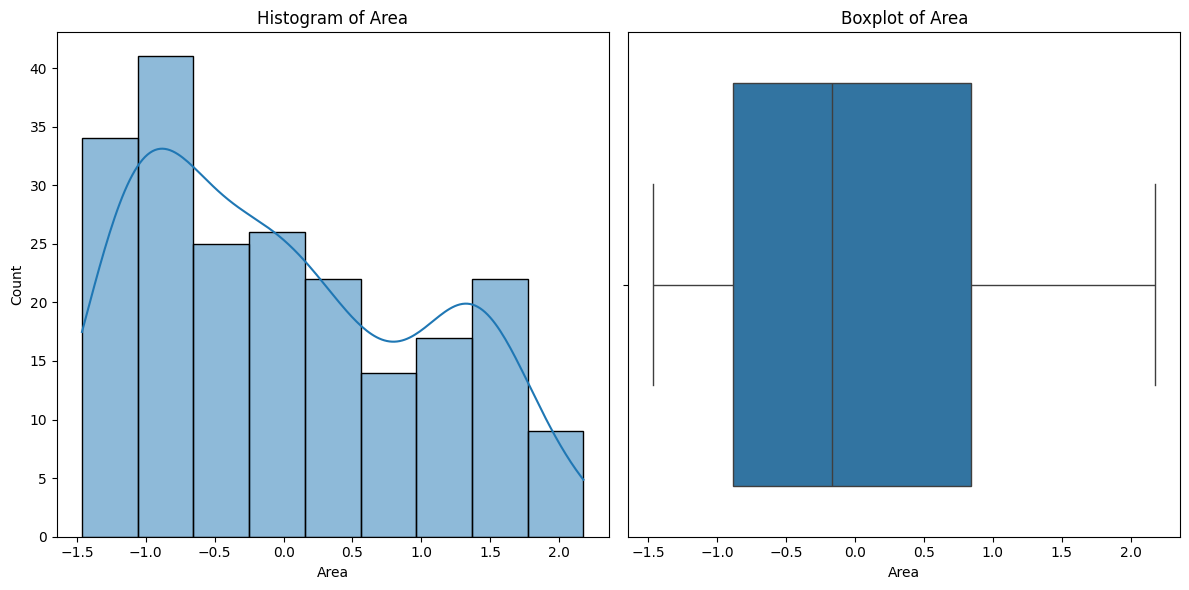

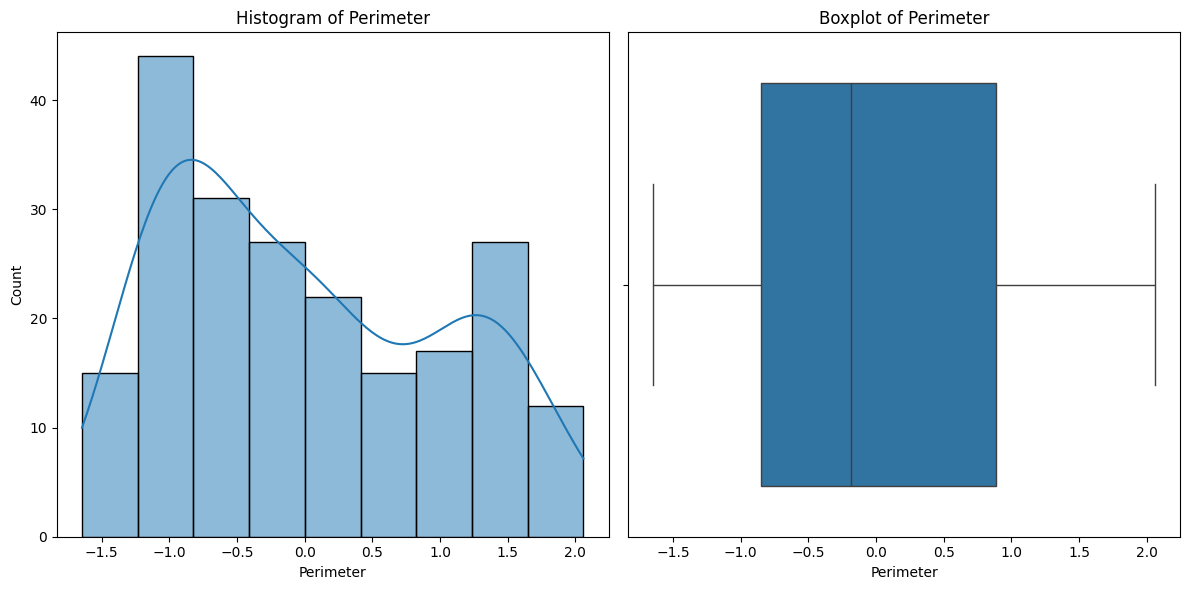

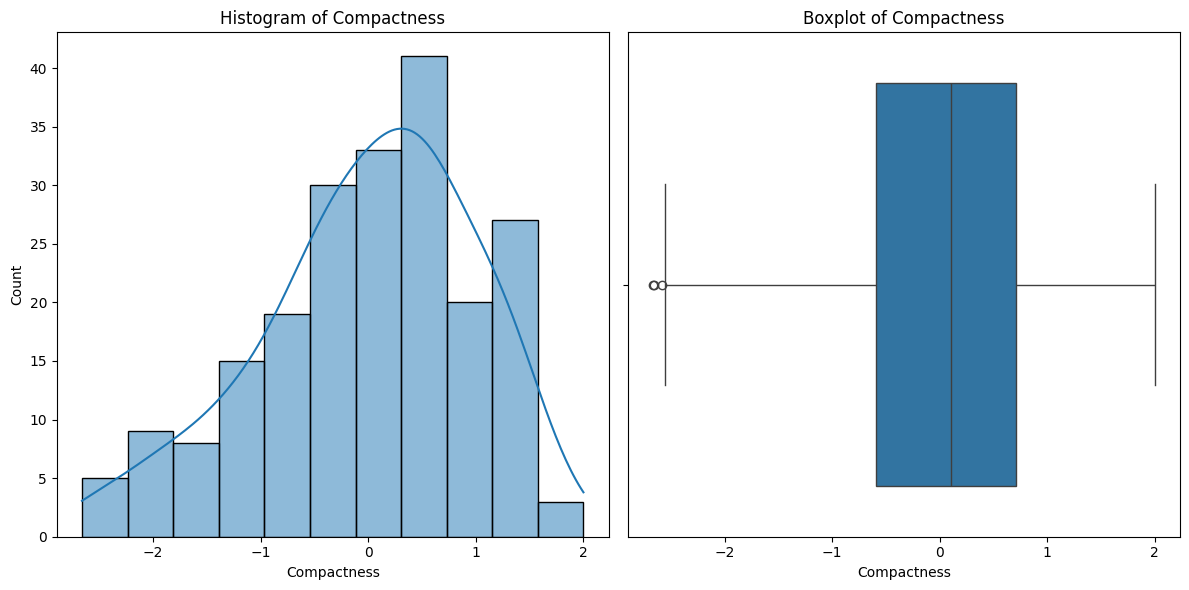

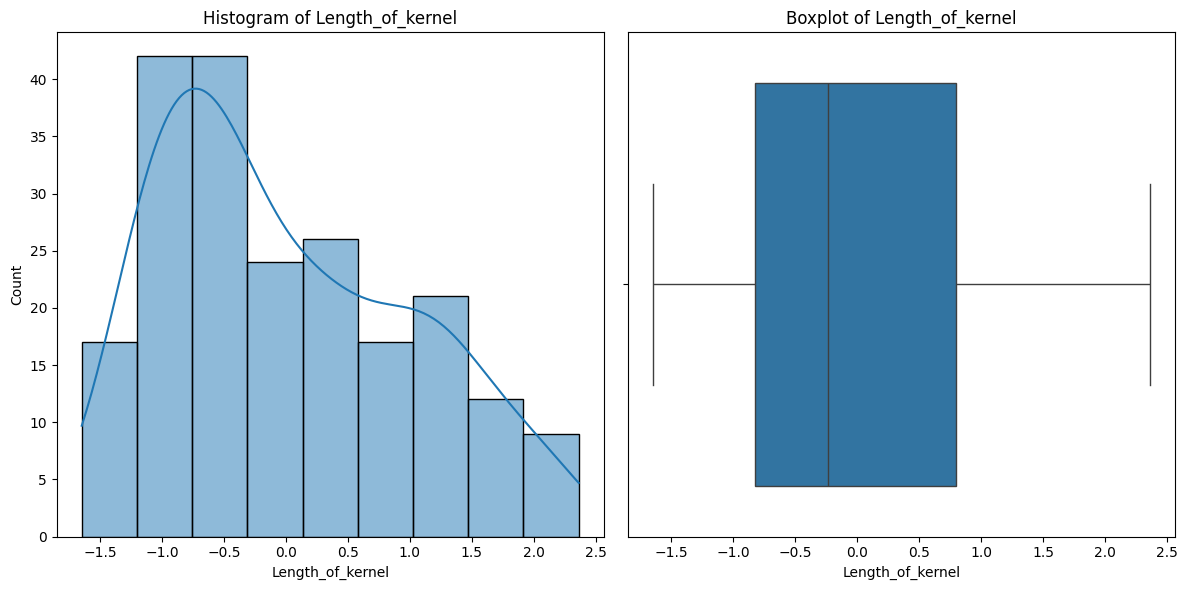

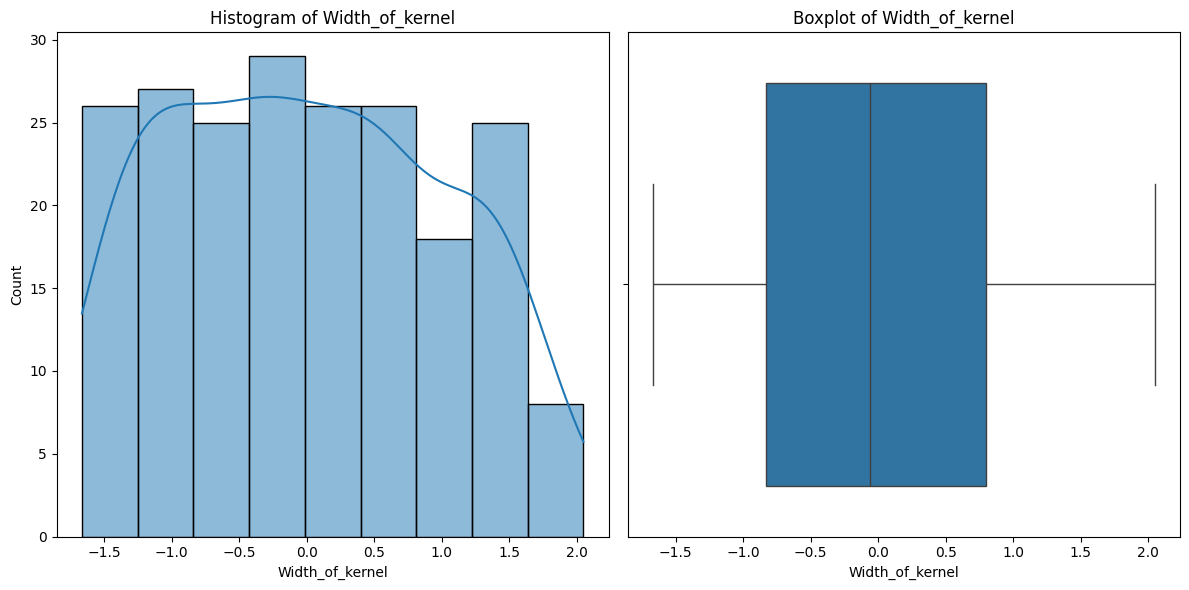

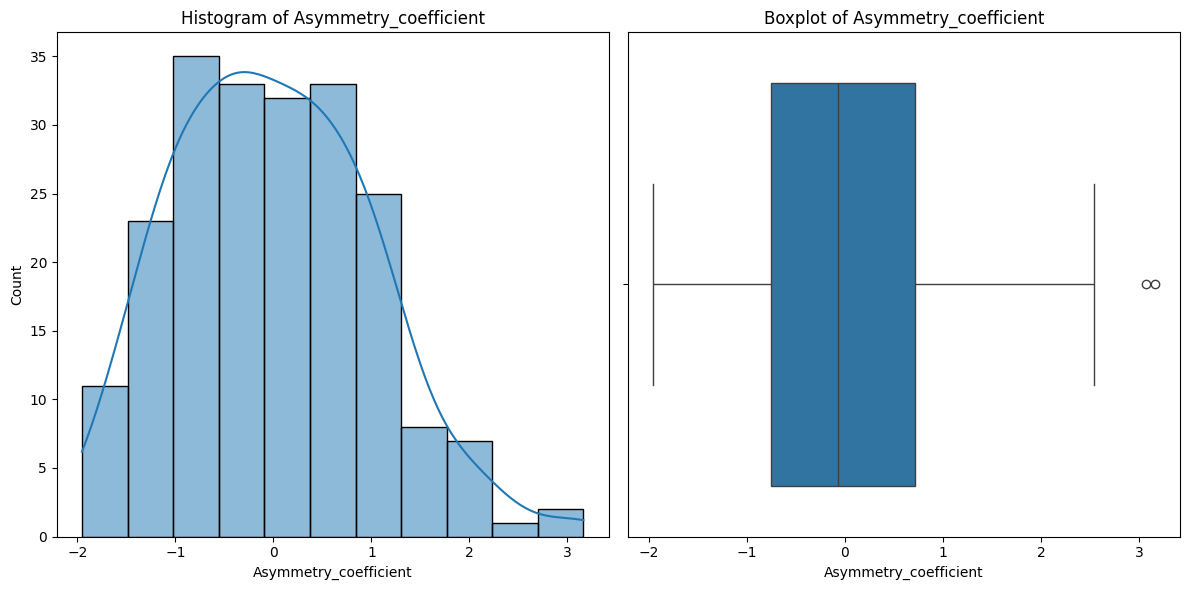

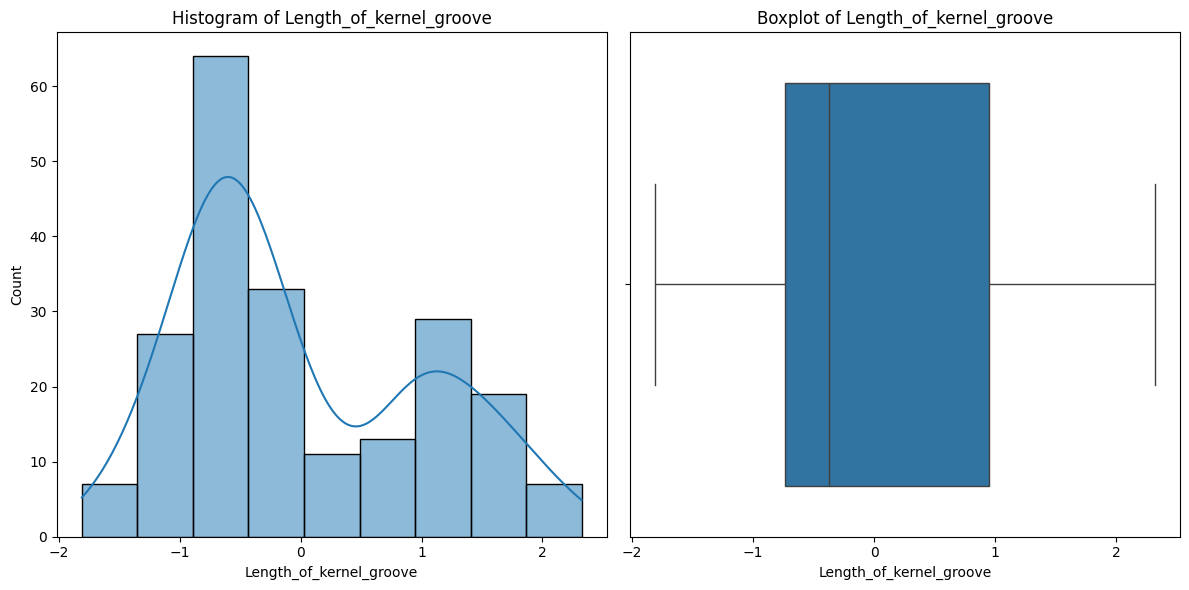

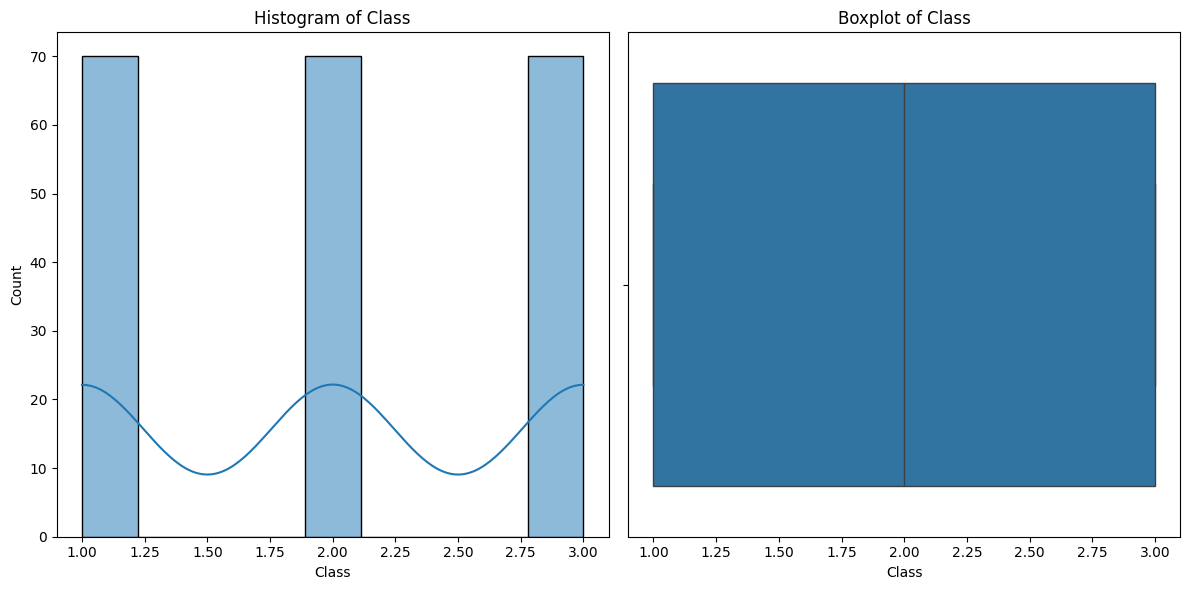

,Accuracy,Precision,Recall,F1-Score
0,0.36,0.37,0.36,0.36


In [174]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
model = KMeans()
params = {'n_clusters':[3]}
column_names = ['Area', 'Perimeter', 'Compactness', 'Length_of_kernel', 'Width_of_kernel', 'Asymmetry_coefficient', 'Length_of_kernel_groove', 'Class']
master(url, column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='Seeds')

## Interpretation of KMeans on Seeds Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.36</td>
      <td>0.37</td>
      <td>0.36</td>
      <td>0.36</td>
    </tr>
  </tbody>
</table>
</div>

**Moderate Performance**: The metrics, including accuracy, precision, recall, and F1-score, are around 0.36. While not high, these scores indicate some level of performance in clustering the data.

**Balanced Precision and Recall**: The precision and recall scores are approximately equal, suggesting that the clusters identified by the algorithm have a relatively balanced distribution of true positives and false positives.

**Room for Improvement**: The F1-score, which combines precision and recall, also stands at around 0.36. While not negligible, there's certainly room for improvement in the algorithm's ability to accurately identify clusters.

**Consideration of Domain Knowledge**: Understanding the Seeds dataset and its characteristics could provide insights into whether this level of performance is satisfactory. Domain knowledge can help determine if the clusters identified align with meaningful patterns in the data.

**Further Analysis Needed**: It would be beneficial to delve deeper into the clusters produced by the algorithm, examining their characteristics and assessing their usefulness for the intended application.

# Iris Dataset

The **Iris Dataset** is a classic dataset in the field of machine learning and statistics. It was used in R.A. Fisher's 1936 paper, "The Use of Multiple Measurements in Taxonomic Problems"³. Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository⁴
- **Subject Area**: Biology⁴
- **Associated Tasks**: Classification, Clustering⁴
- **Feature Type**: Real⁴
- **Instances**: 150⁴
- **Features**: 4⁴
- **Classes**: 3⁴

The dataset consists of 50 samples from each of three species of Iris flowers (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the lengths and the widths of the sepals and petals⁴.

The column names for the dataset are:

- Sepal Length
- Sepal Width
- Petal Length
- Petal Width
- Class

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information⁴.

Source: Conversation with Bing, 20/02/2024
(1) scikit-learn/iris · Datasets at Hugging Face. https://huggingface.co/datasets/scikit-learn/iris.
(2) Iris - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Iris.
(3) The Iris Dataset · GitHub. https://gist.github.com/curran/a08a1080b88344b0c8a7.
(4) The Iris Dataset — scikit-learn 1.4.1 documentation. https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html.
(5) A Complete Guide to the Iris Dataset in R - Statology. https://www.statology.org/iris-dataset-r/.
(6) undefined. https://vizhub.com/curran/3d631093c2334030a6b27fa979bb4a0d?edit=files&file=index.js.
(7) undefined. https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.9/d3.min.js.

5-Number Summary:
              count  mean  std   min   25%   50%  75%  max
sepal_length 147.00 -0.00 1.00 -1.88 -0.91 -0.07 0.66 2.46
sepal_width  147.00  0.00 1.00 -2.42 -0.59 -0.13 0.56 3.08
petal_length 147.00 -0.00 1.00 -1.58 -1.24  0.35 0.75 1.77
petal_width  147.00 -0.00 1.00 -1.46 -1.20  0.12 0.78 1.70
class        147.00  1.01 0.82  0.00  0.00  1.00 2.00 2.00


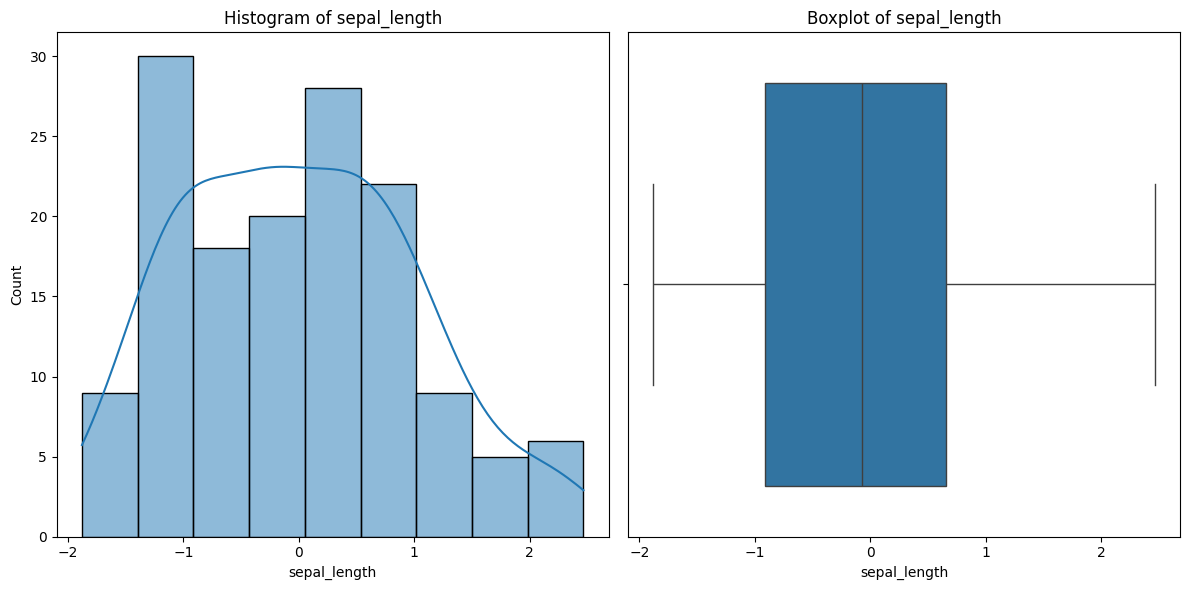

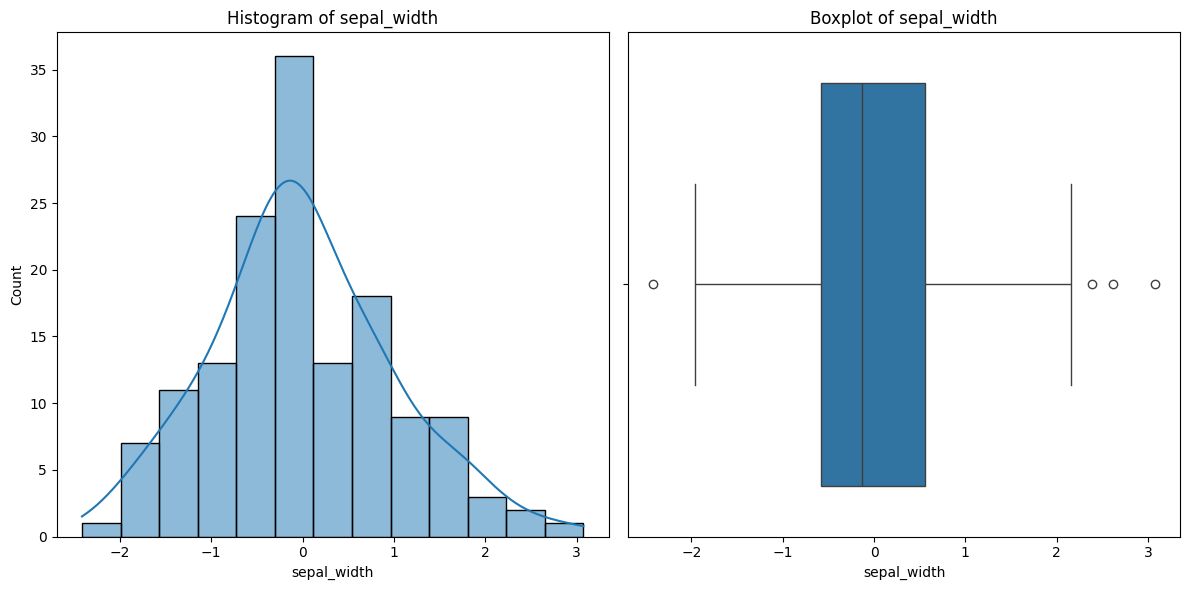

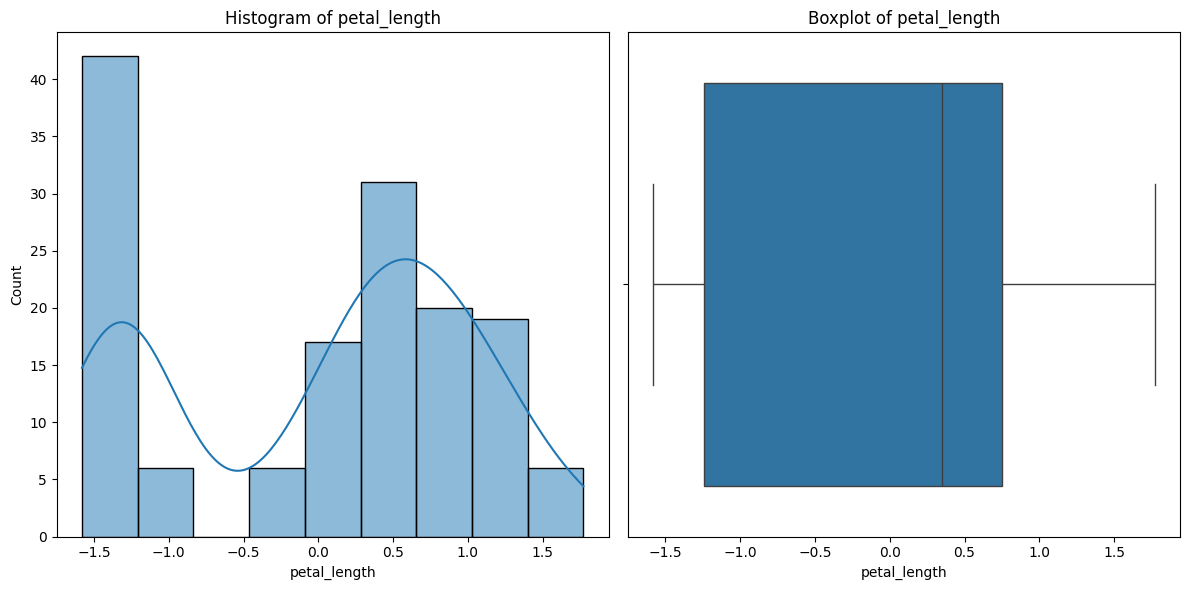

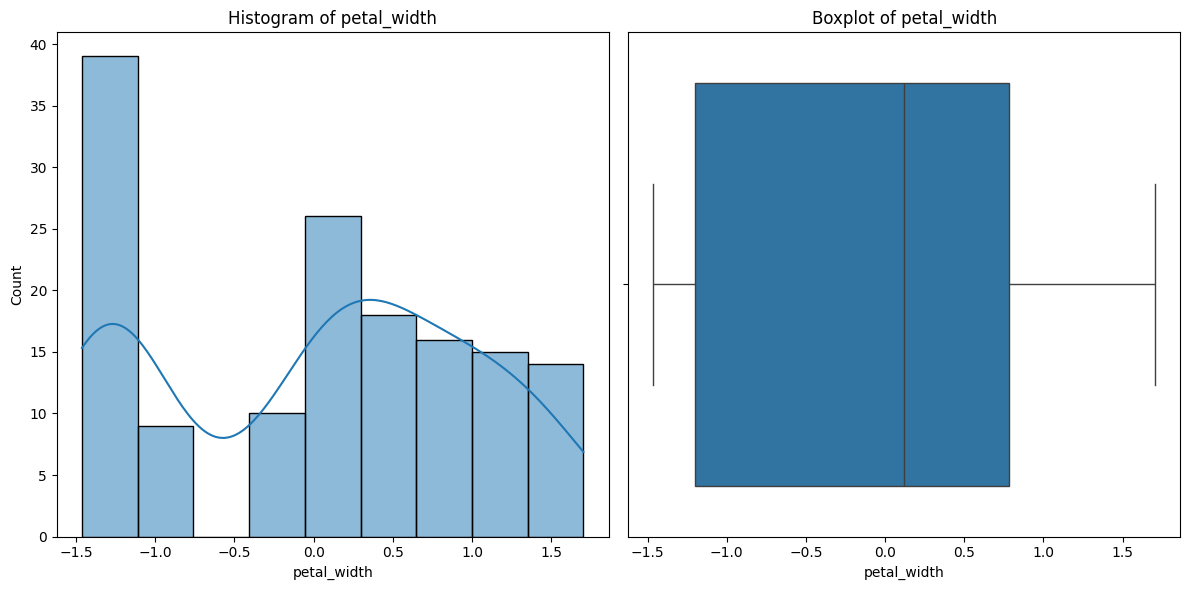

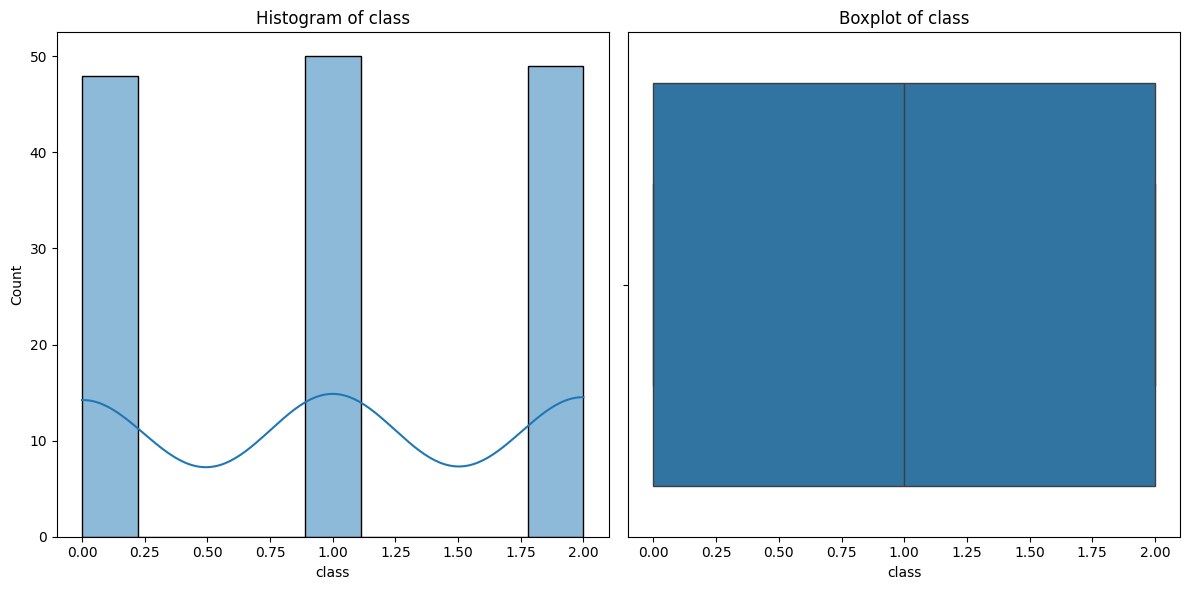

,Accuracy,Precision,Recall,F1-Score
0,0.10,0.07,0.10,0.08


In [175]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

master(url, column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='Iris')

## Interpretation of KMeans on Iris Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.10</td>
      <td>0.07</td>
      <td>0.10</td>
      <td>0.08</td>
    </tr>
  </tbody>
</table>
</div>

**Low Performance**: Across all metrics (accuracy, precision, recall, and F1-score), the scores are extremely low, hovering around 0.1. This indicates that the model's performance is poor.

**Consistent but Ineffective**: While the metrics show consistency in their low values, it suggests that the model is not effectively capturing the underlying patterns in the Iris dataset.

**Minimal Discriminatory Power**: The low scores across metrics suggest that the model struggles to distinguish between different classes of iris flowers based on the provided features.

**Potential Issues**: These poor results could stem from various factors such as inappropriate choice of algorithm (k-means is not typically used for classification tasks), insufficient feature engineering, or inadequate preprocessing of the dataset.

**Further Investigation Needed**: To improve model performance, it would be necessary to explore alternative algorithms suitable for classification tasks, conduct thorough feature engineering, and ensure proper preprocessing of the dataset.

# Credit Approval Dataset

The **Credit Approval** dataset from the UCI Machine Learning Repository is a multivariate dataset that concerns credit card applications¹. Here are some details about this dataset:

- **Subject Area**: Business¹
- **Associated Tasks**: Classification¹
- **Feature Type**: Categorical, Integer, Real¹
- **Number of Instances**: 690¹
- **Number of Features**: 15¹
- **Has Missing Values?**: Yes¹

The dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values¹. All attribute names and values have been changed to meaningless symbols to protect the confidentiality of the data¹.

Here are the variable names and their types:

```markdown
- A1: b, a
- A2: continuous
- A3: continuous
- A4: u, y, l, t
- A5: g, p, gg
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff
- A7: v, h, bb, j, n, z, dd, ff, o
- A8: continuous
- A9: t, f
- A10: t, f
- A11: continuous
- A12: t, f
- A13: g, p, s
- A14: continuous
- A15: continuous
- A16: +,- (class attribute)
```

Please note that all attribute names and values in the dataset have been changed to meaningless symbols to protect the confidentiality of the data¹.

Source: Conversation with Bing, 20/02/2024
(1) Credit Approval - UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/27/credit+approval.
(2) UCI Credit Approval | Kaggle. https://www.kaggle.com/datasets/echo9k/uci-credit-approval.
(3) GitHub - mnchl-kim/Credit-Approval: UCI Machine Learning Repository .... https://github.com/mnchl-kim/Credit-Approval.
(4) Statlog (German Credit Data) - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29.
(5) undefined. https://archive.ics.uci.edu/ml/datasets/credit+approval%29.

5-Number Summary:
     count   mean   std   min   25%    50%    75%    max
A1  690.00   1.66  0.51  0.00  1.00   2.00   2.00   2.00
A2  690.00 150.53 96.19  0.00 71.00 133.50 226.00 349.00
A3  690.00   0.00  1.00 -0.96 -0.76  -0.40   0.49   4.67
A4  690.00   2.22  0.48  0.00  2.00   2.00   2.00   3.00
A5  690.00   1.47  0.86  0.00  1.00   1.00   1.00   3.00
A6  690.00   6.67  4.32  0.00  2.00   6.00  11.00  14.00
A7  690.00   5.99  2.59  0.00  4.00   8.00   8.00   9.00
A8  690.00   0.00  1.00 -0.66 -0.62  -0.37   0.12   7.85
A9  690.00   0.52  0.50  0.00  0.00   1.00   1.00   1.00
A10 690.00   0.43  0.50  0.00  0.00   0.00   1.00   1.00
A11 690.00   0.00  1.00 -0.49 -0.49  -0.49   0.12  13.28
A12 690.00   0.46  0.50  0.00  0.00   0.00   1.00   1.00
A13 690.00   0.18  0.56  0.00  0.00   0.00   0.00   2.00
A14 690.00  59.39 48.23  0.00 23.00  52.00  96.00 170.00
A15 690.00   0.00  1.00 -0.20 -0.20  -0.19  -0.12  19.00
A16 690.00   0.56  0.50  0.00  0.00   1.00   1.00   1.00


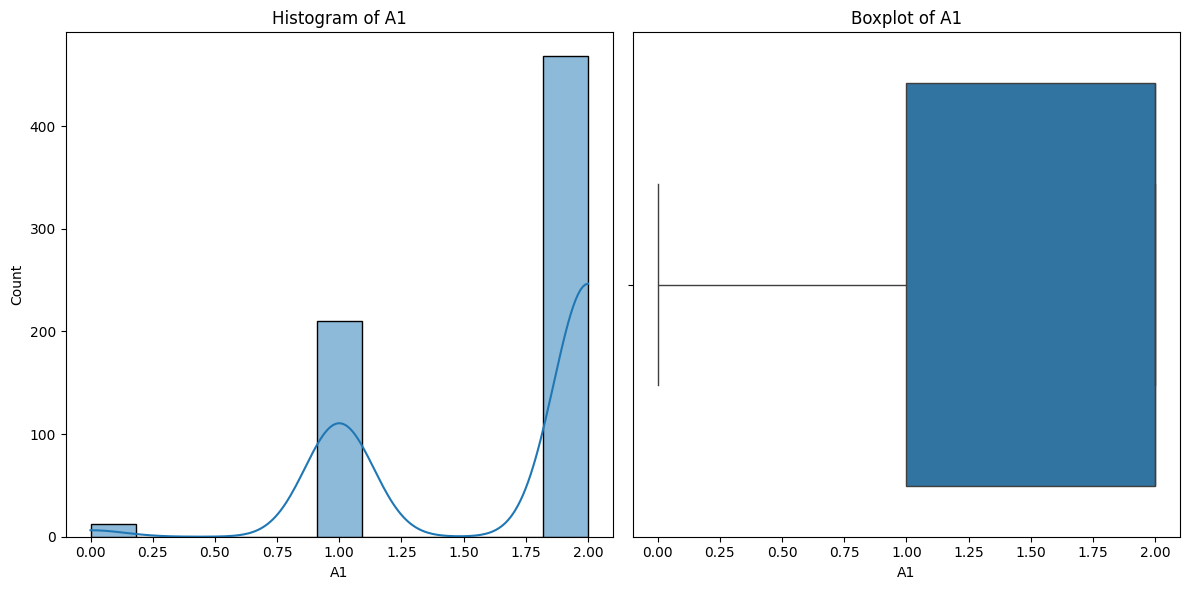

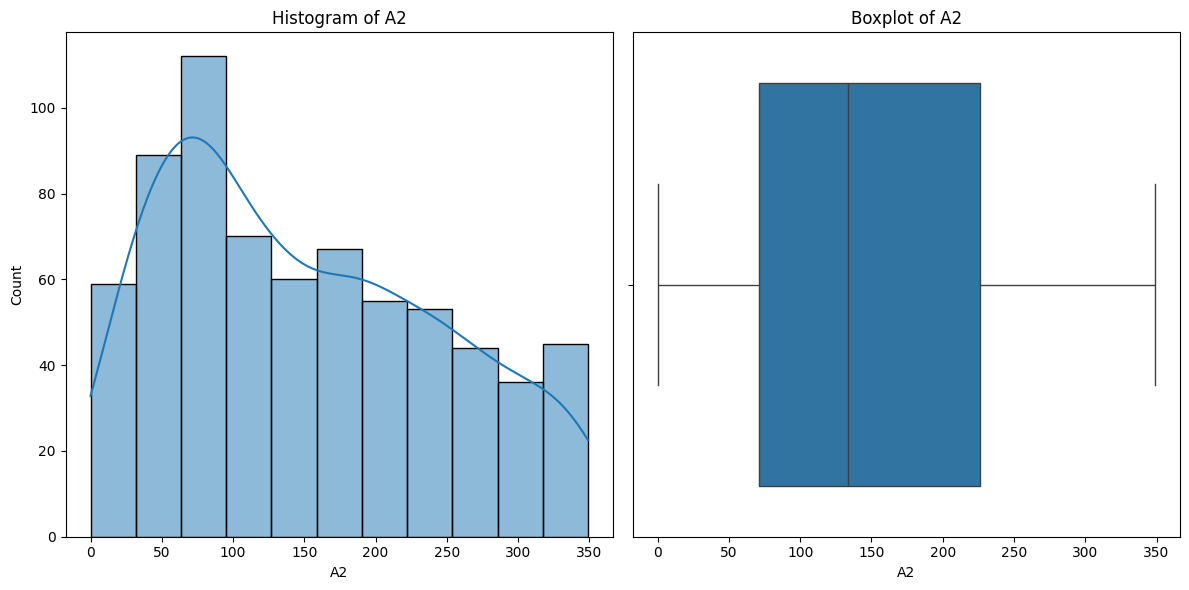

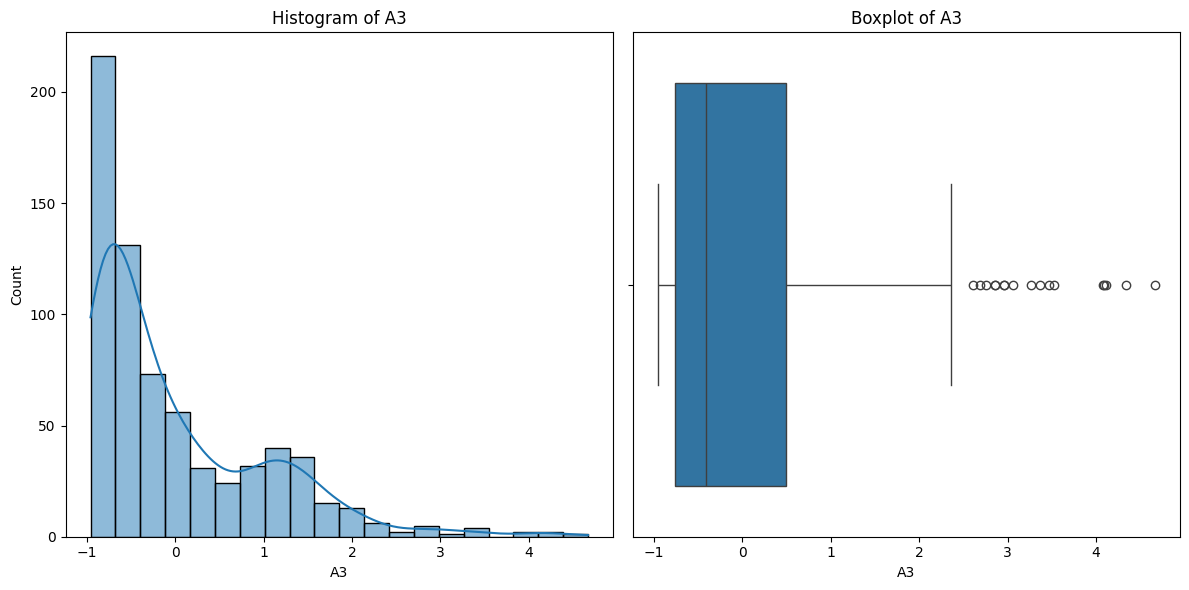

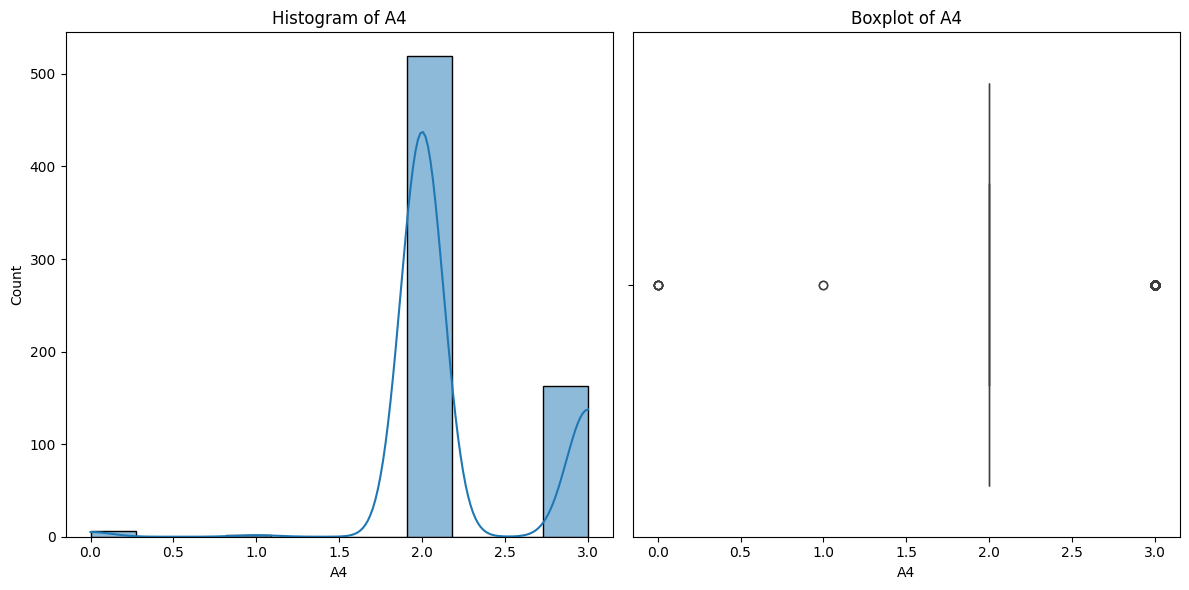

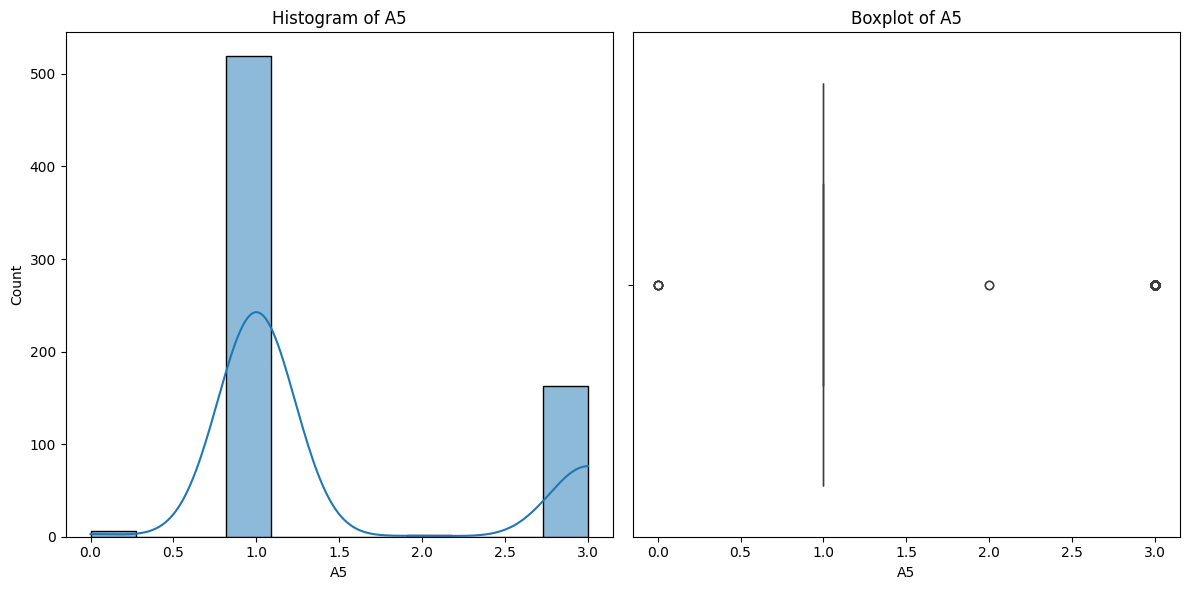

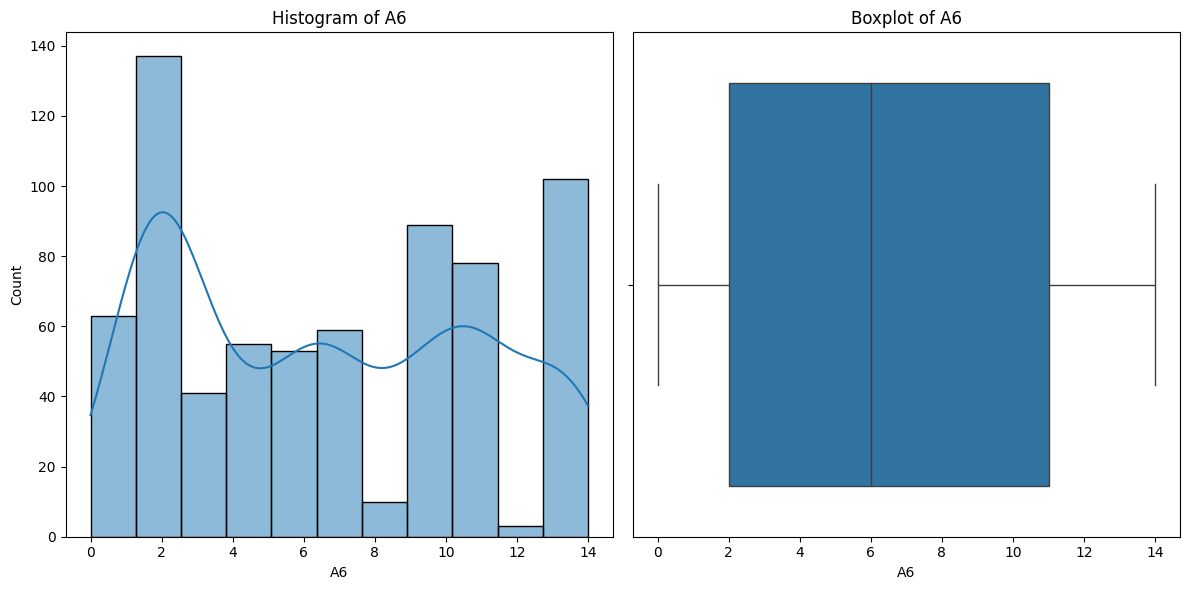

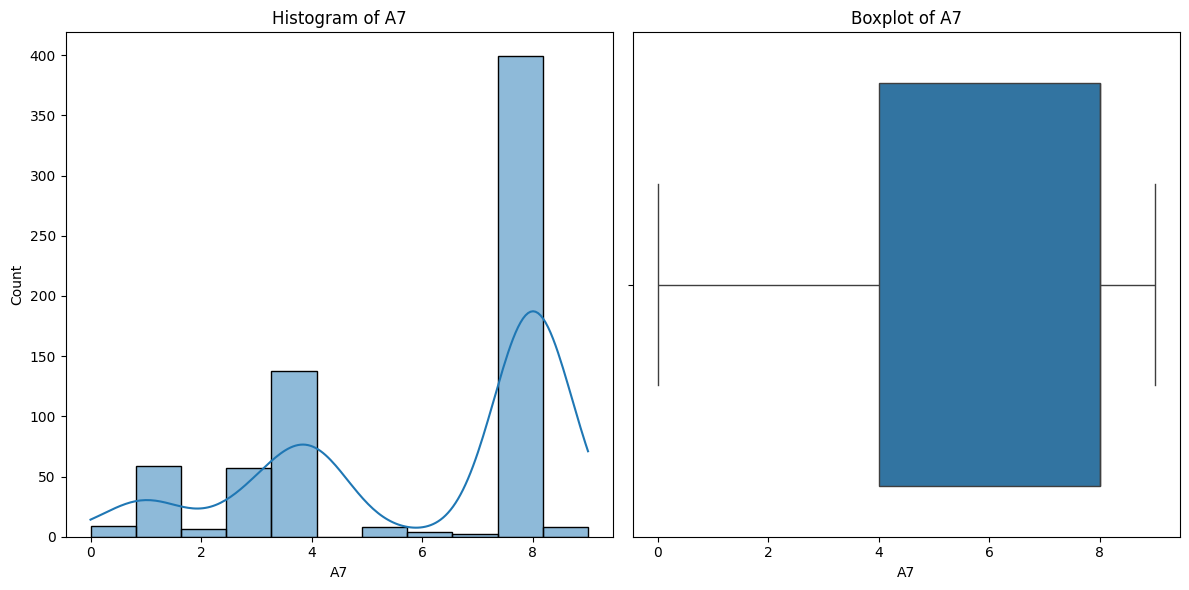

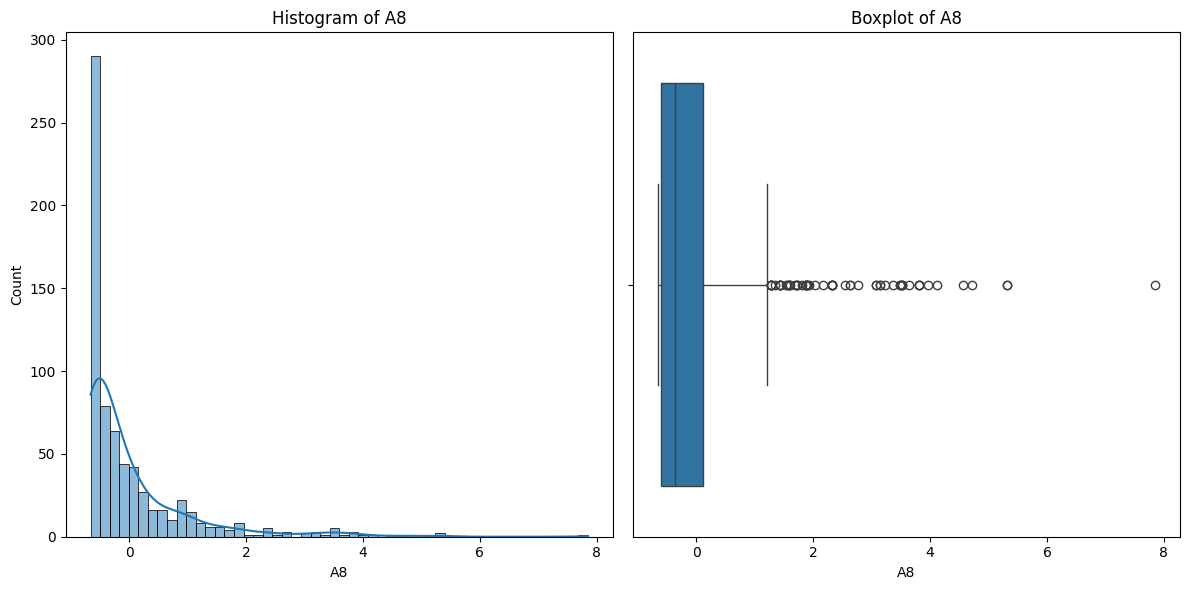

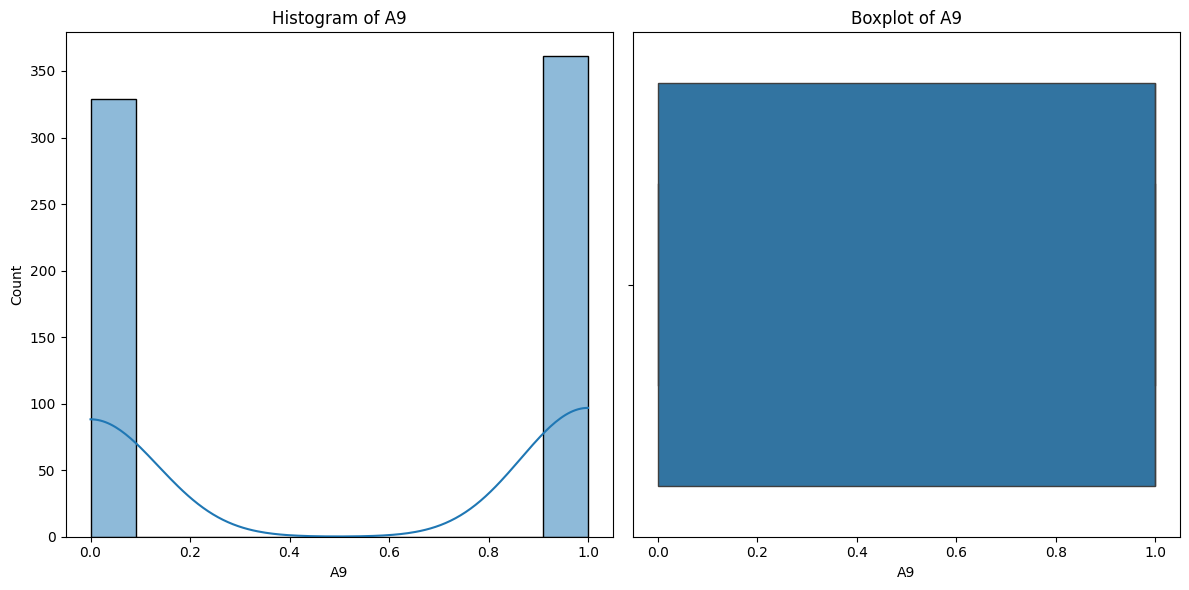

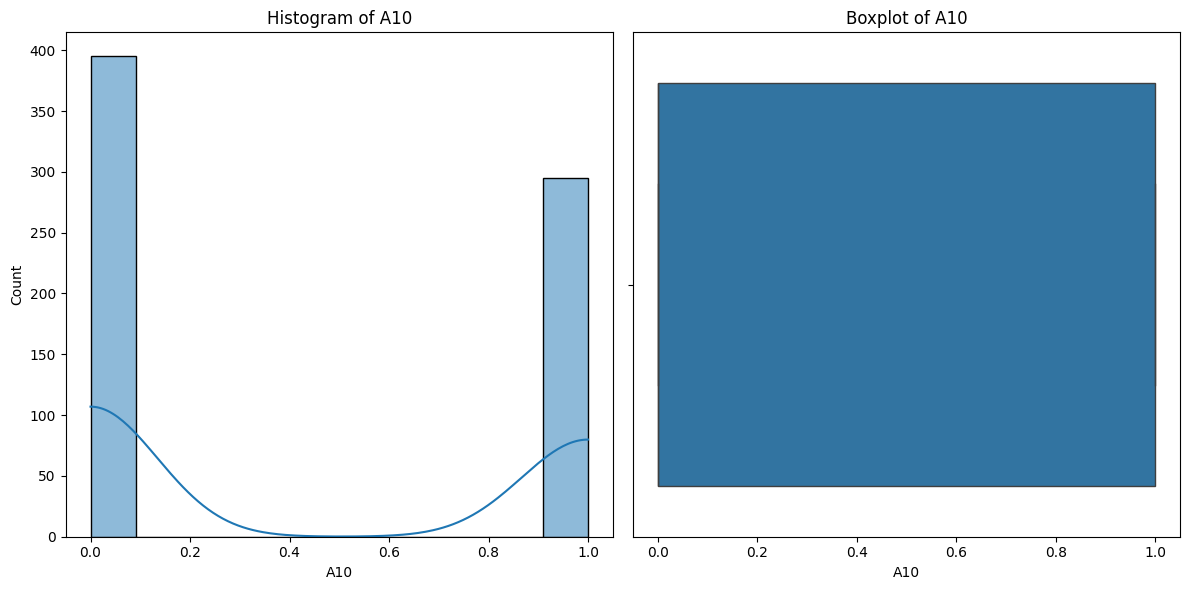

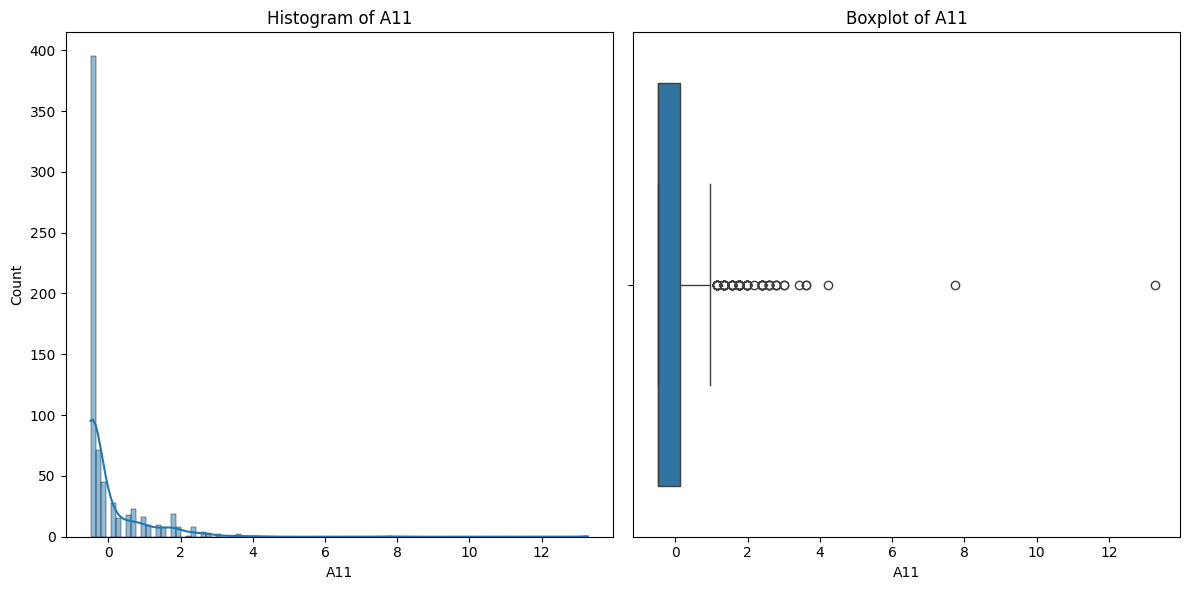

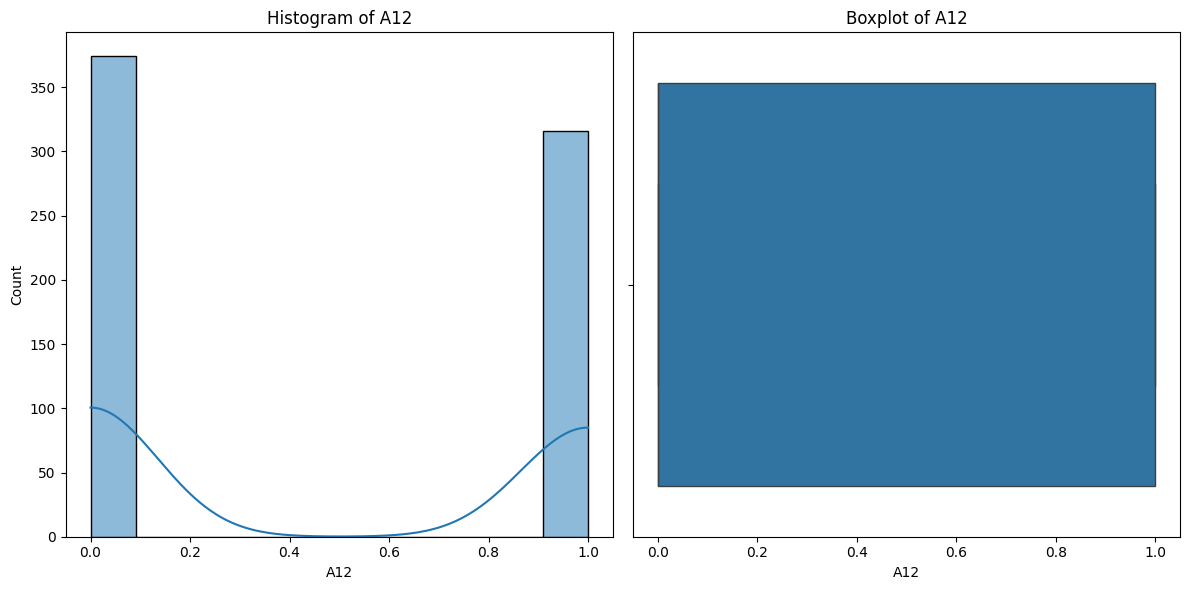

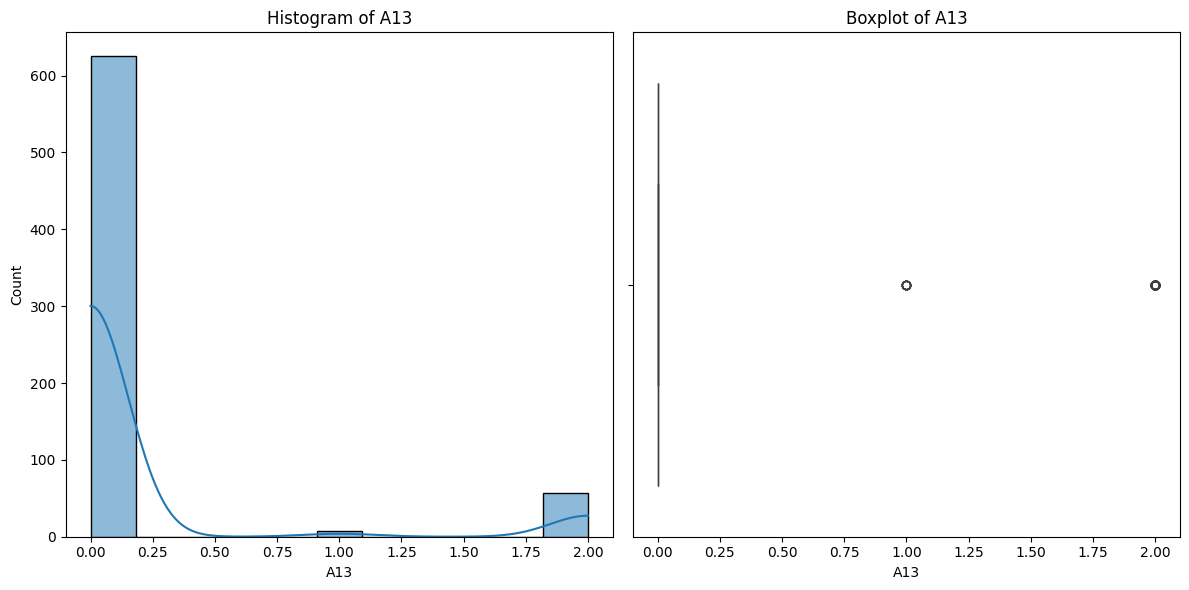

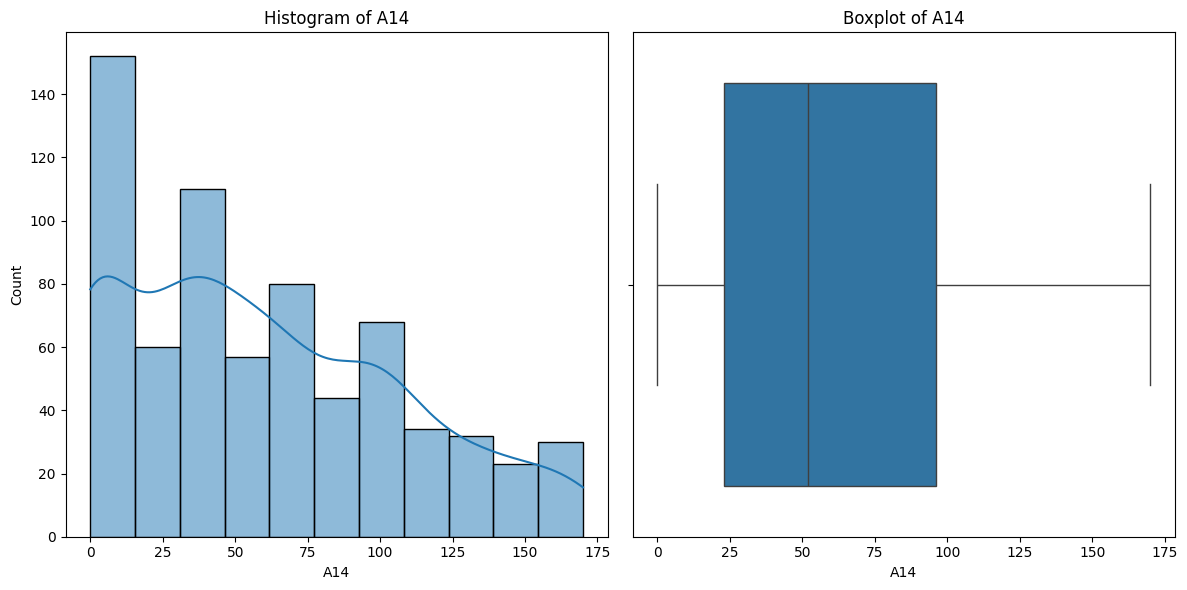

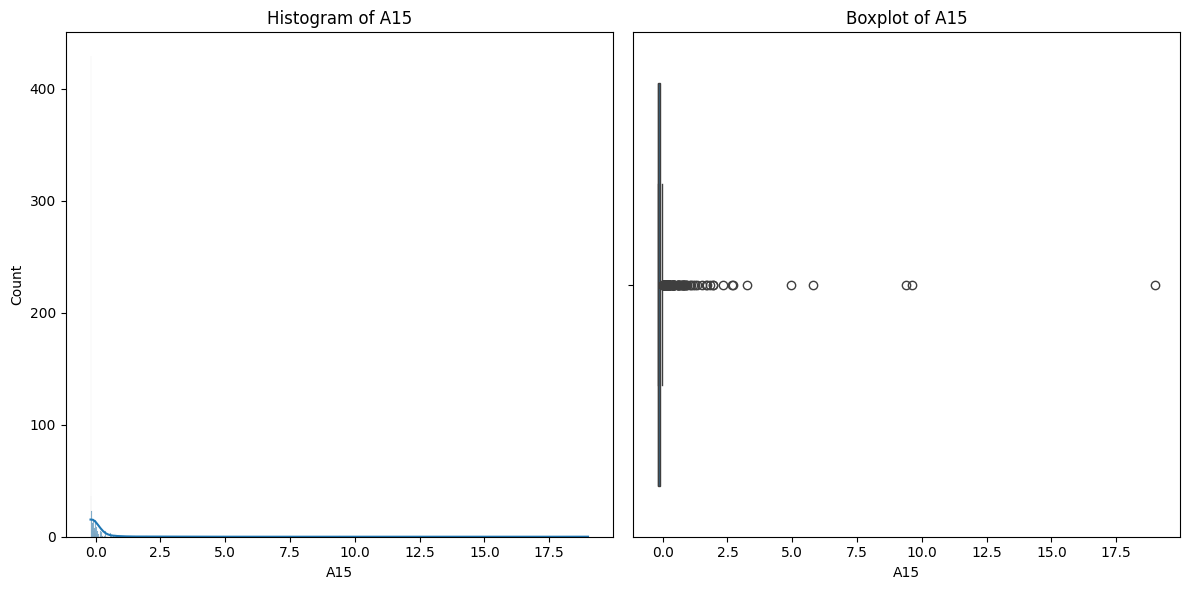

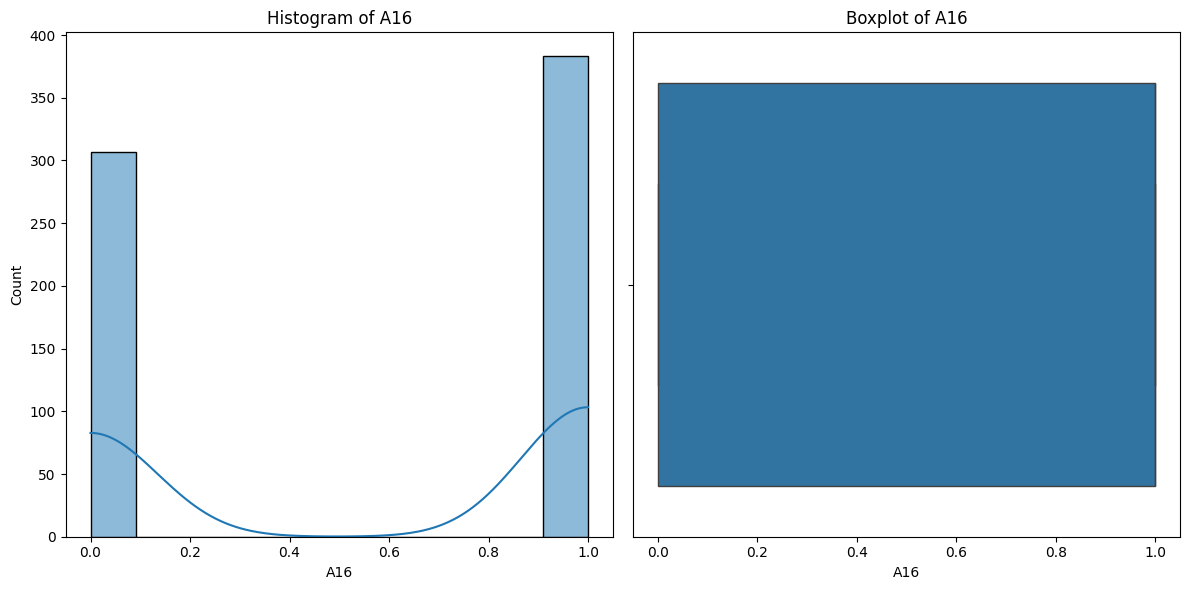

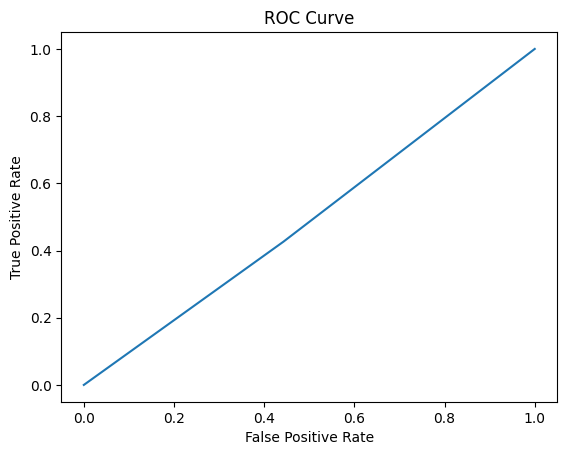

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.49,0.49,0.49,0.49,0.49


In [176]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
column_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16']

model = KMeans()
params = {'n_clusters':[2]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='credit_approval')

## Interpretation of KMeans on Credit Card Approval
<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>ROC-AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.49</td>
      <td>0.49</td>
      <td>0.49</td>
      <td>0.49</td>
      <td>0.49</td>
    </tr>
  </tbody>
</table>
</div>

**Poor Performance**: All metrics, including accuracy, precision, recall, F1-score, and ROC-AUC, are around 0.49, indicating very low performance.

**Consistent but Ineffective**: While the metrics are consistent across different evaluation criteria, they are uniformly low, suggesting the model is not effectively capturing patterns or making accurate predictions.

**Low Discriminatory Power**: The low ROC-AUC score indicates the model's inability to distinguish between positive and negative classes, implying it struggles to differentiate between approved and rejected credit card applications.

**Possible Issues**: Potential reasons for poor performance could include inadequate feature selection, the unsuitability of the k-means algorithm for classification tasks, or insufficient preprocessing of the dataset.

**Further Investigation Needed**: To improve model performance, additional analysis such as exploring the dataset, trying different algorithms, feature engineering, or hyperparameter tuning is necessary.

# Heart Disease Dataset

The **Heart Disease Dataset** is a comprehensive collection of heart disease information that has been widely used in machine learning for classification tasks². It was donated to the UCI Machine Learning Repository on June 30, 1988².

Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository²
- **Subject Area**: Health and Medicine²
- **Associated Tasks**: Classification²
- **Feature Type**: Categorical, Integer, Real²
- **Instances**: 303²
- **Features**: 13²

The dataset contains 76 attributes, but all published experiments refer to using a subset of 14 of them². The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4².

The 14 commonly used attributes are²:

- Age
- Sex
- Chest pain type (cp)
- Resting blood pressure (trestbps)
- Serum cholesterol in mg/dl (chol)
- Fasting blood sugar > 120 mg/dl (fbs)
- Resting electrocardiographic results (restecg)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang)
- ST depression induced by exercise relative to rest (oldpeak)
- The slope of the peak exercise ST segment (slope)
- Number of major vessels (0-3) colored by flourosopy (ca)
- Thal: 3 = normal; 6 = fixed defect; 7 = reversible defect (thal)
- Diagnosis of heart disease (angiographic disease status) (num)

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information².

Source: Conversation with Bing, 20/02/2024
(1) Heart Disease - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease.
(2) Heart Disease Dataset | Kaggle. https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset.
(3) Cardiac Atlas Project – sharing a large-scale database of cardiac .... https://www.cardiacatlas.org/.
(4) Data | Centers for Disease Control and Prevention. https://data.cdc.gov/browse/select_dataset?tags=heart+disease.
(5) Heart Disease Dataset (Comprehensive) | IEEE DataPort. https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive.
(6) Bayesian network in Python using pgmpy - VTUPulse. https://vtupulse.com/machine-learning/bayesian-network-in-python-using-pgmpy/.
(7) Heart Disease Dataset UCI | Kaggle. https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci.
(8) UCI Heart Disease Analysis - GitHub. https://github.com/stat432/heart-analysis.
(9) Heart failure clinical records - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records.
(10) Statlog (Heart) - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29.
(11) Heart Disease - Classifications (Machine Learning) | Kaggle. https://www.kaggle.com/code/cdabakoglu/heart-disease-classifications-machine-learning.
(12) Heart Disease Classification | Kaggle. https://www.kaggle.com/code/microvision/heart-disease-classification.
(13) An Extensive Dataset for the Heart Disease Classification System. https://data.mendeley.com/datasets/65gxgy2nmg/2.

5-Number Summary:
          count  mean  std   min   25%   50%   75%  max
age      303.00 -0.00 1.00 -2.81 -0.71  0.17  0.73 2.50
sex      303.00 -0.00 1.00 -1.45 -1.45  0.69  0.69 0.69
cp       303.00 -0.00 1.00 -2.25 -0.16 -0.16  0.88 0.88
trestbps 303.00  0.00 1.00 -2.14 -0.66 -0.10  0.47 3.88
chol     303.00  0.00 1.00 -2.33 -0.69 -0.11  0.55 6.13
fbs      303.00  0.00 1.00 -0.42 -0.42 -0.42 -0.42 2.39
restecg  303.00  0.00 1.00 -1.00 -1.00  0.01  1.02 1.02
thalach  303.00 -0.00 1.00 -3.44 -0.70  0.15  0.72 2.29
exang    303.00 -0.00 1.00 -0.70 -0.70 -0.70  1.43 1.43
oldpeak  303.00 -0.00 1.00 -0.90 -0.90 -0.21  0.48 4.44
slope    303.00  0.00 1.00 -0.97 -0.97  0.65  0.65 2.27
ca       303.00  0.72 1.01  0.00  0.00  0.00  1.00 4.00
thal     303.00  0.85 0.97  0.00  0.00  0.00  2.00 3.00
num      303.00  0.94 1.23  0.00  0.00  0.00  2.00 4.00


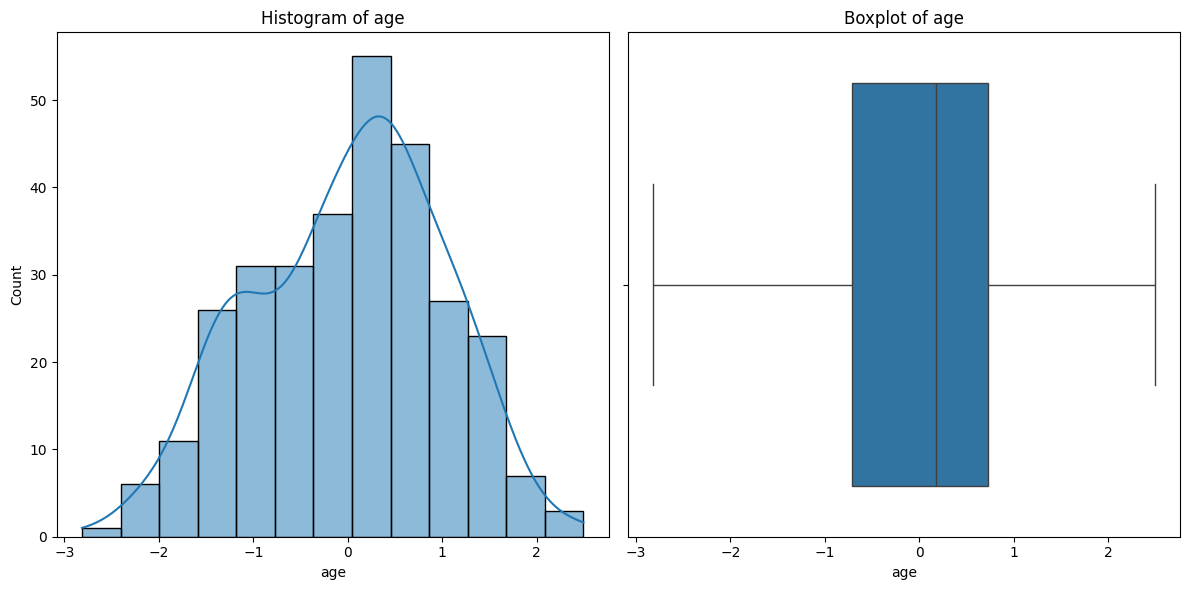

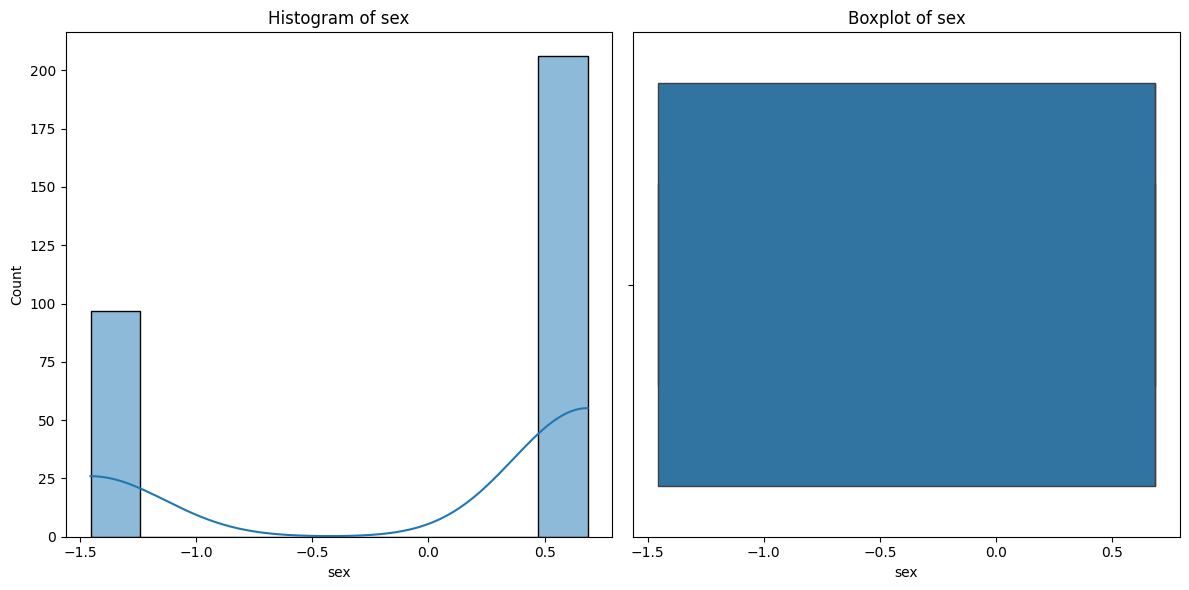

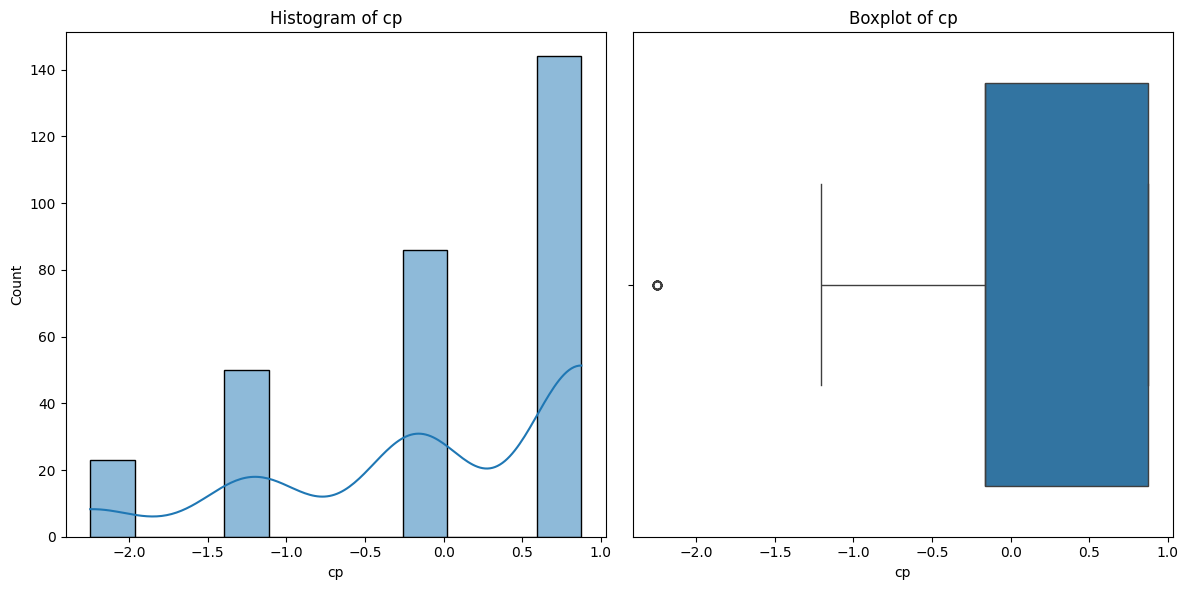

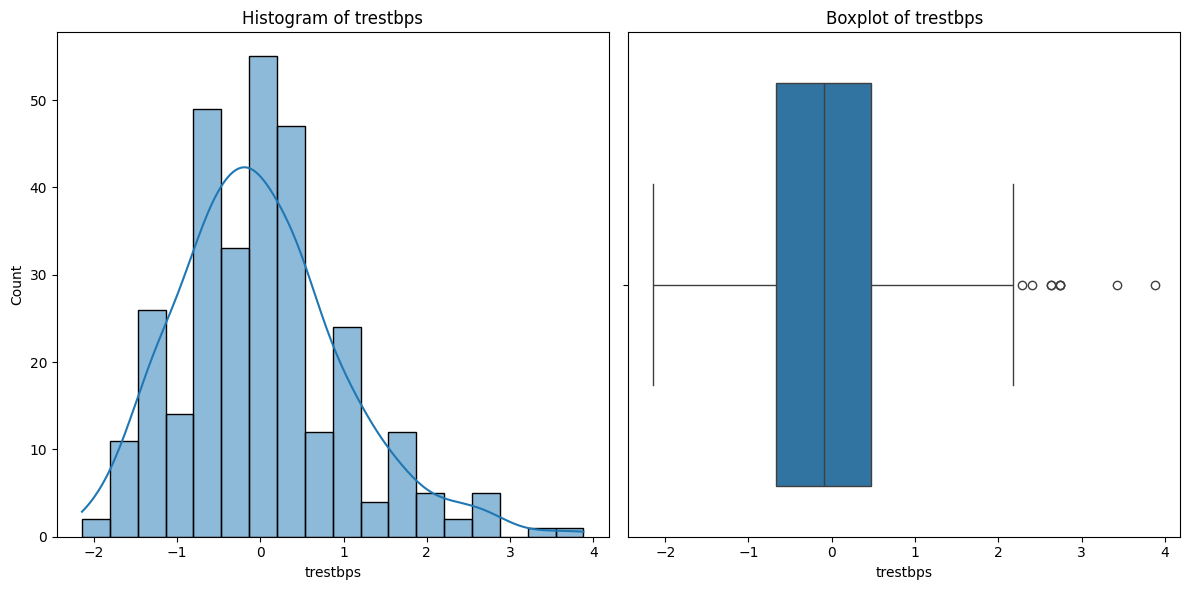

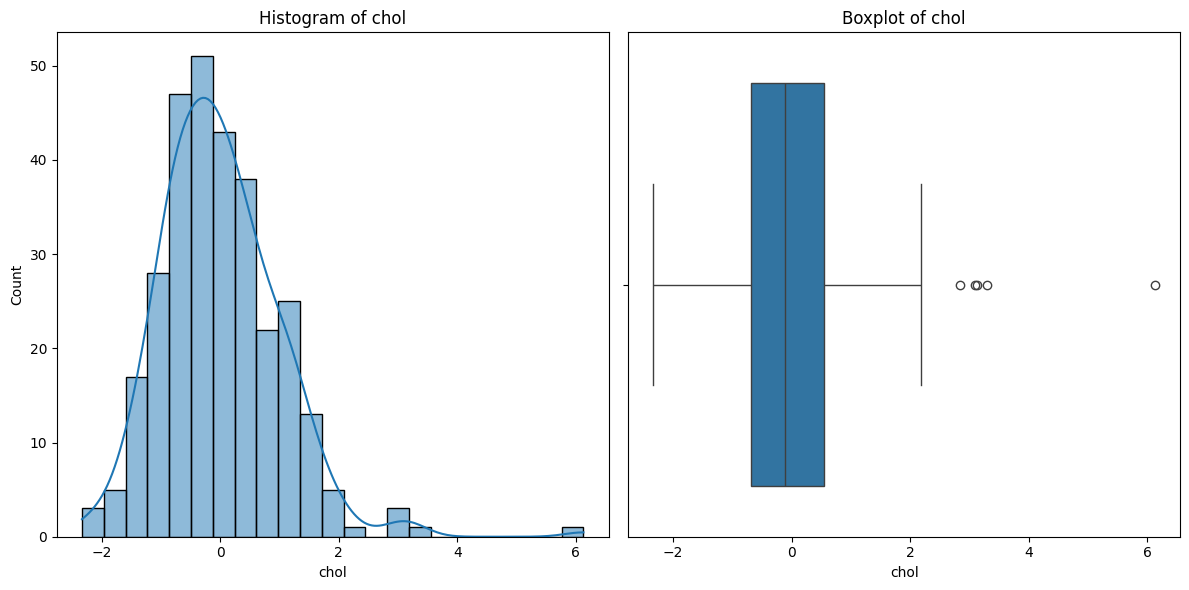

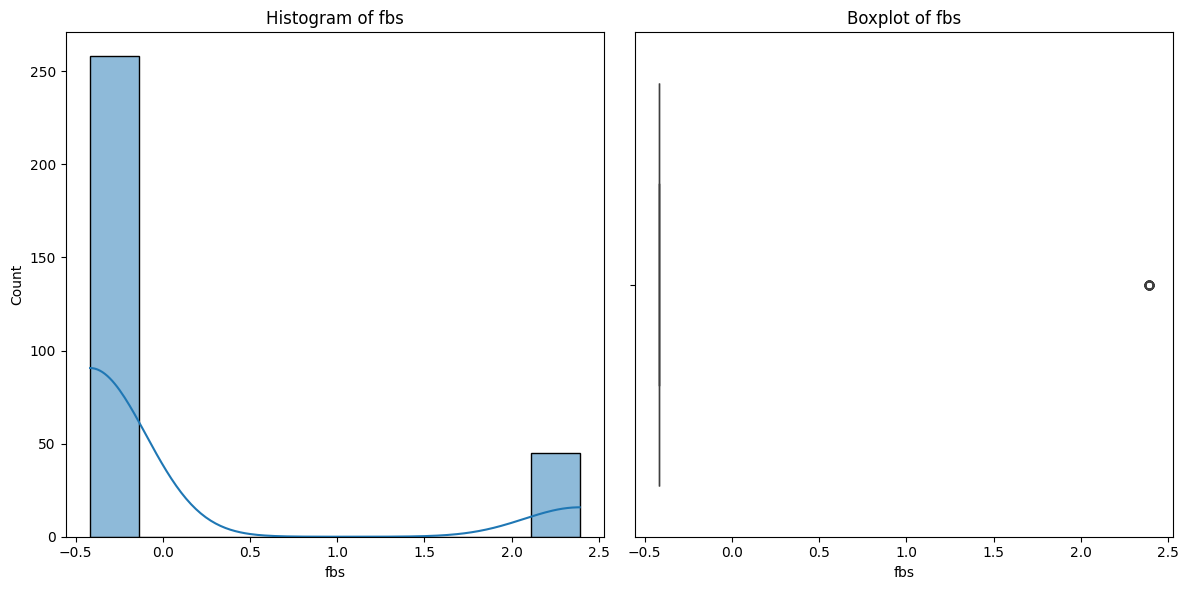

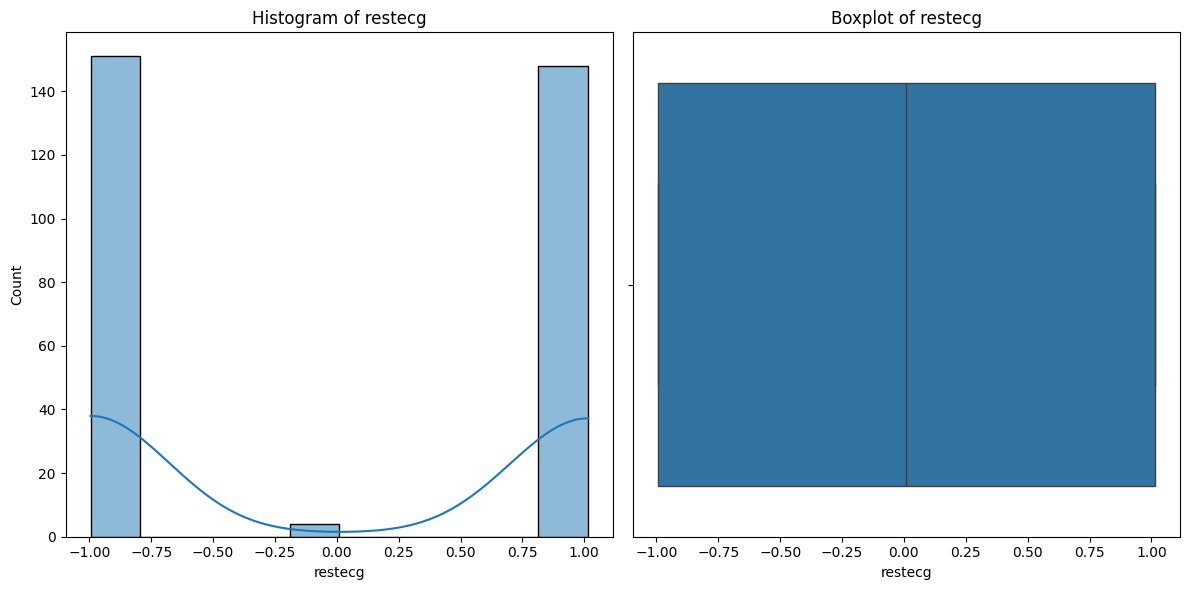

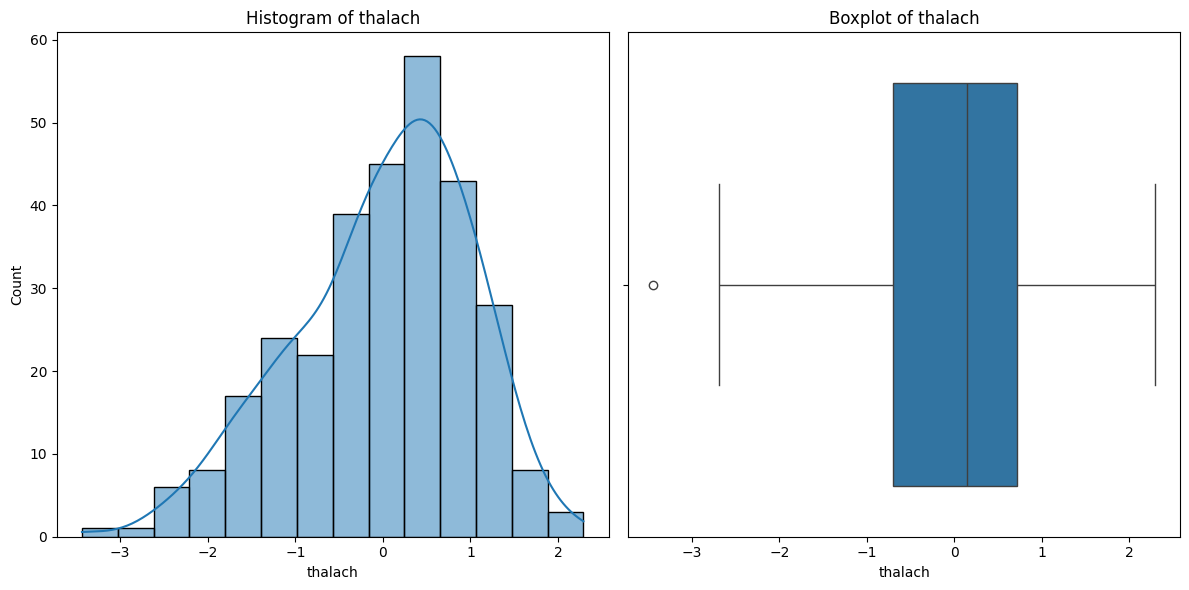

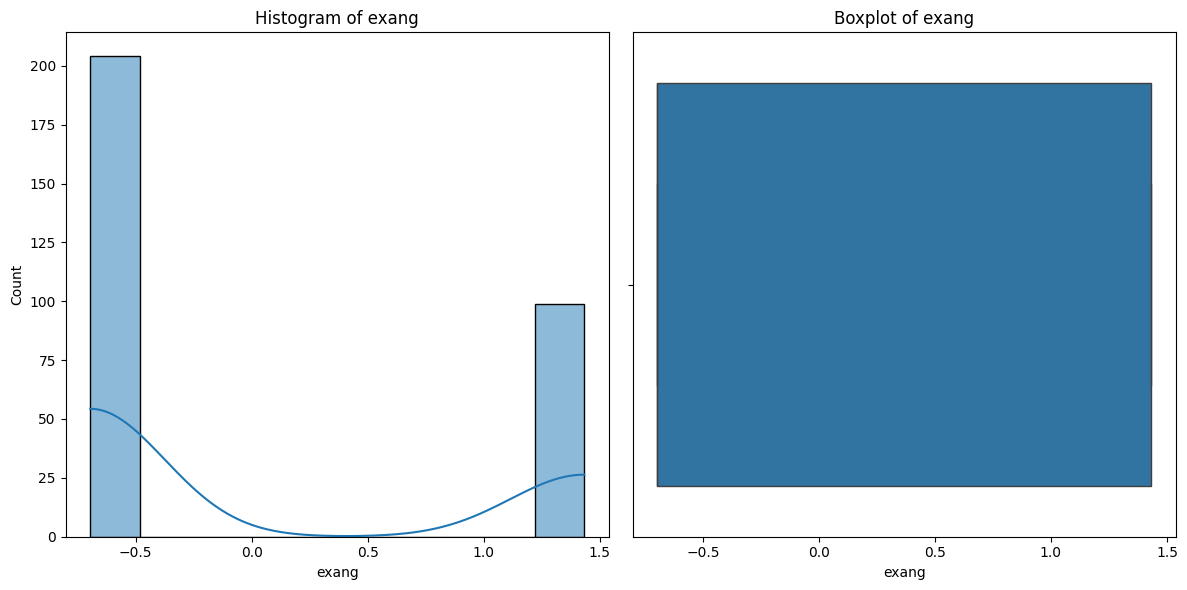

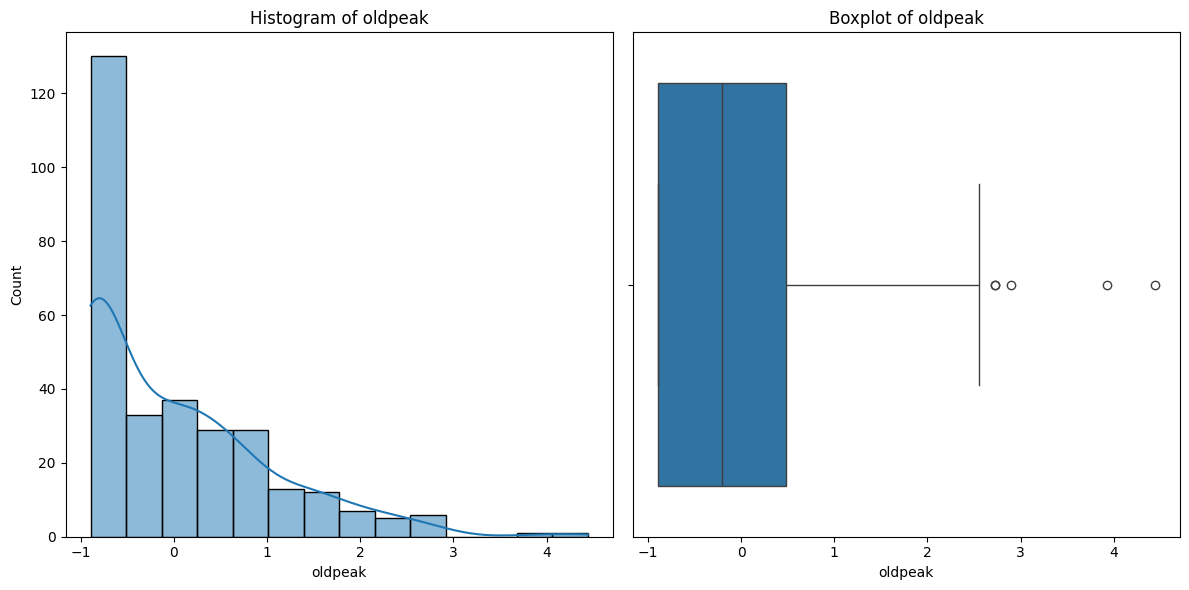

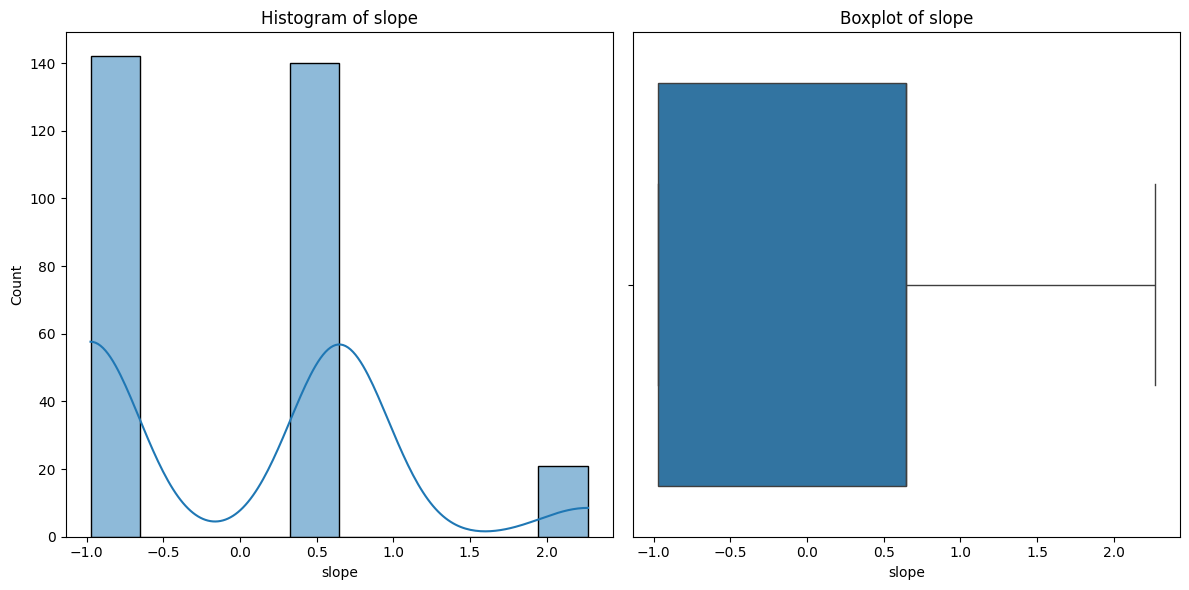

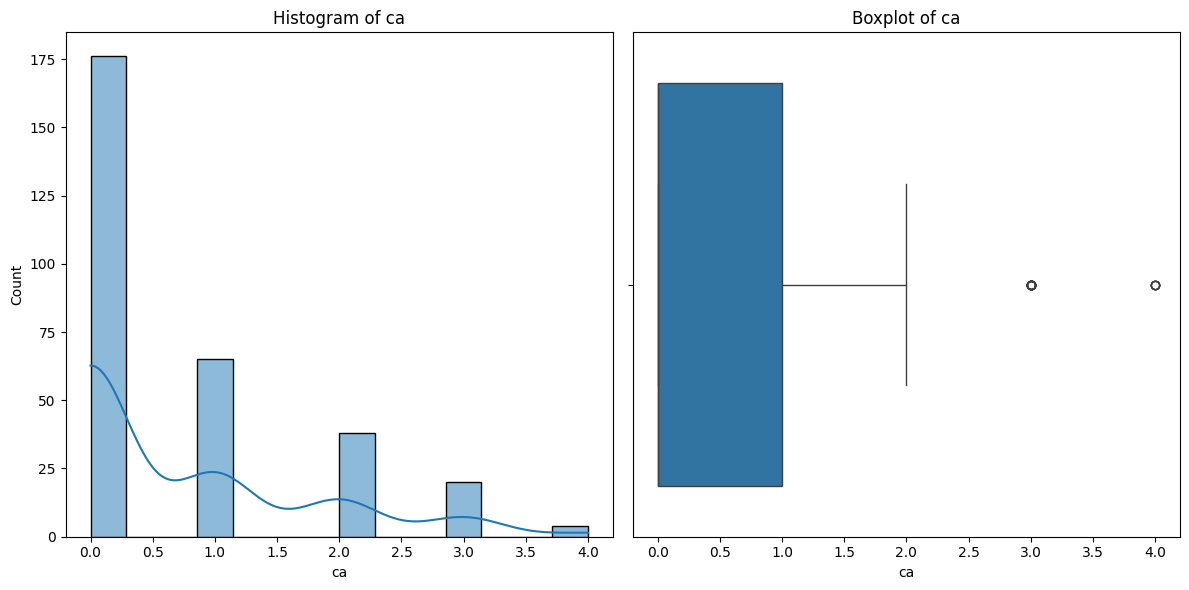

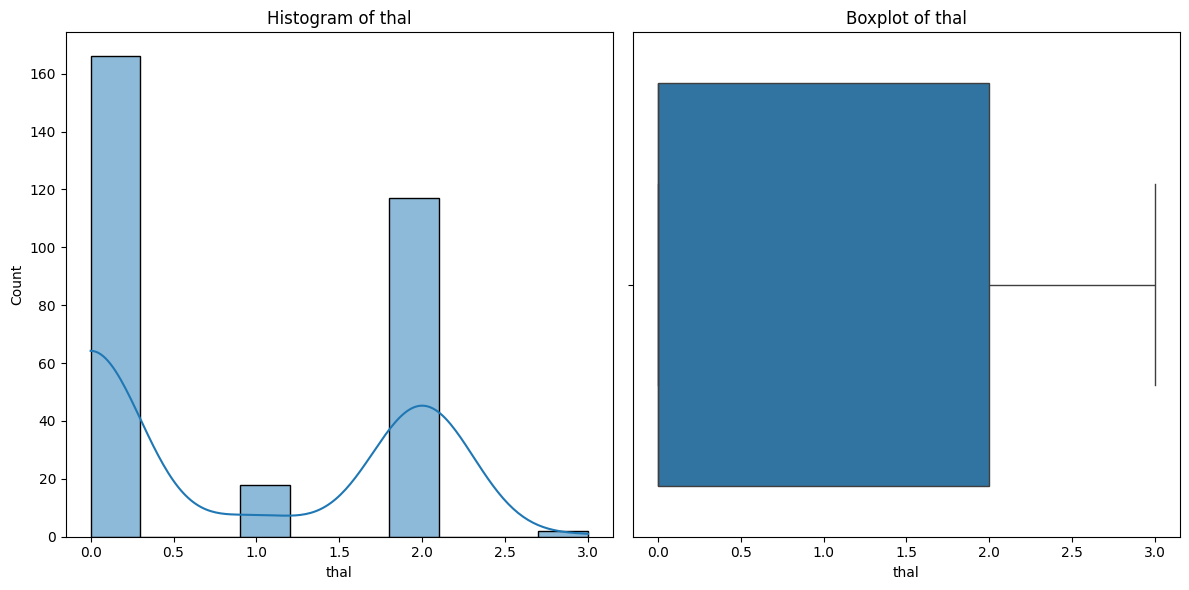

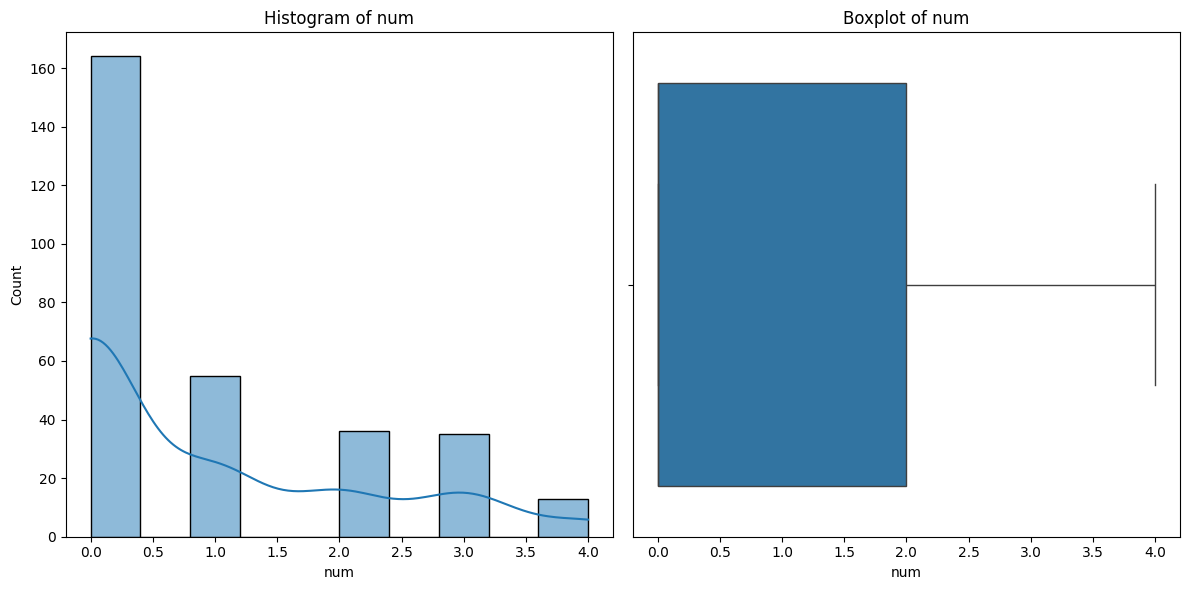

,Accuracy,Precision,Recall,F1-Score
0,0.52,0.42,0.52,0.46


In [177]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"]

model = KMeans()
params = {'n_clusters':[2]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='Heart Disease')

## Interpretation of KMeans on Heart Disease Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.52</td>
      <td>0.42</td>
      <td>0.52</td>
      <td>0.46</td>
    </tr>
  </tbody>
</table>
</div>

**Limited Performance**: The metrics are relatively low, with accuracy at 0.52, precision at 0.42, recall at 0.52, and F1-score at 0.46. These scores suggest that the clustering algorithm's performance on the Heart Disease dataset is modest.

**Balanced Recall and Precision**: It's notable that the recall and precision values are close, indicating a somewhat balanced performance in identifying positive instances (heart disease cases) while minimizing false positives.

**Room for Improvement**: While the algorithm is able to identify some patterns within the data, there is significant room for improvement in terms of accuracy and overall predictive capability.

**Consideration of Domain Knowledge**: Understanding the characteristics and intricacies of the Heart Disease dataset is crucial for interpreting these results accurately. Domain knowledge can help determine whether the clustering produced by the algorithm aligns with known patterns or insights in the field of cardiology.

**Further Evaluation Needed**: Given the modest performance metrics, further evaluation of the clustering results is warranted. This could involve analyzing the clusters generated, assessing their coherence and interpretability, and potentially exploring alternative clustering algorithms or parameter settings to improve performance.


# Pima Indians Diabetes Dataset

The Pima Indians Diabetes Dataset is a multivariate dataset that can be used for classification tasks³. Here are some details about the dataset:

- **Data Types**: Multivariate³
- **Task**: Classification³
- **Attribute Types**: Integer, Real³
- **Instances**: 768³
- **Attributes**: 8³
- **Year**: 1990³
- **Area**: Life³
- **Description**: The dataset is from the National Institute of Diabetes and Digestive and Kidney Diseases³. It includes cost data donated by Peter Turney³.

The dataset is comprised of 768 observations of medical details for Pima Indians patients⁵. The attributes include the number of times pregnant, plasma glucose concentration, diastolic blood pressure, triceps skin fold thickness, 2-hour serum insulin, body mass index, diabetes pedigree function, and age⁵. The target variable is a binary variable that indicates whether or not a patient has diabetes⁵.

Please note that the availability and format of the dataset might change over time. Always check the dataset's documentation for the most accurate and up-to-date information. Happy data exploring! 😊

Source: Conversation with Bing, 20/02/2024
(1) pima-indians-diabetes | Machine Learning Data - Network Data Repository. https://networkrepository.com/pima-indians-diabetes.php.
(2) LamaHamadeh/Pima-Indians-Diabetes-DataSet-UCI - GitHub. https://github.com/LamaHamadeh/Pima-Indians-Diabetes-DataSet-UCI.
(3) Pima Indians Diabetes Database | Kaggle. https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database.
(4) npradaschnor/Pima-Indians-Diabetes-Dataset - GitHub. https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset.
(5) Kaggle: Your Home for Data Science. https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv/download?datasetVersionNumber=1.
(6) undefined. https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes.

5-Number Summary:
                          count  mean  std   min   25%   50%  75%  max
Pregnancies              768.00 -0.00 1.00 -1.14 -0.84 -0.25 0.64 3.90
Glucose                  768.00 -0.00 1.00 -3.78 -0.68 -0.12 0.61 2.44
BloodPressure            768.00  0.00 1.00 -3.57 -0.37  0.15 0.56 2.73
SkinThickness            768.00  0.00 1.00 -1.29 -1.29  0.15 0.72 4.92
Insulin                  768.00 -0.00 1.00 -0.69 -0.69 -0.43 0.41 6.65
BMI                      768.00  0.00 1.00 -4.06 -0.60  0.00 0.58 4.45
DiabetesPedigreeFunction 768.00  0.00 1.00 -1.19 -0.69 -0.30 0.47 5.88
Age                      768.00  0.00 1.00 -1.04 -0.79 -0.36 0.66 4.06
Outcome                  768.00  0.35 0.48  0.00  0.00  0.00 1.00 1.00


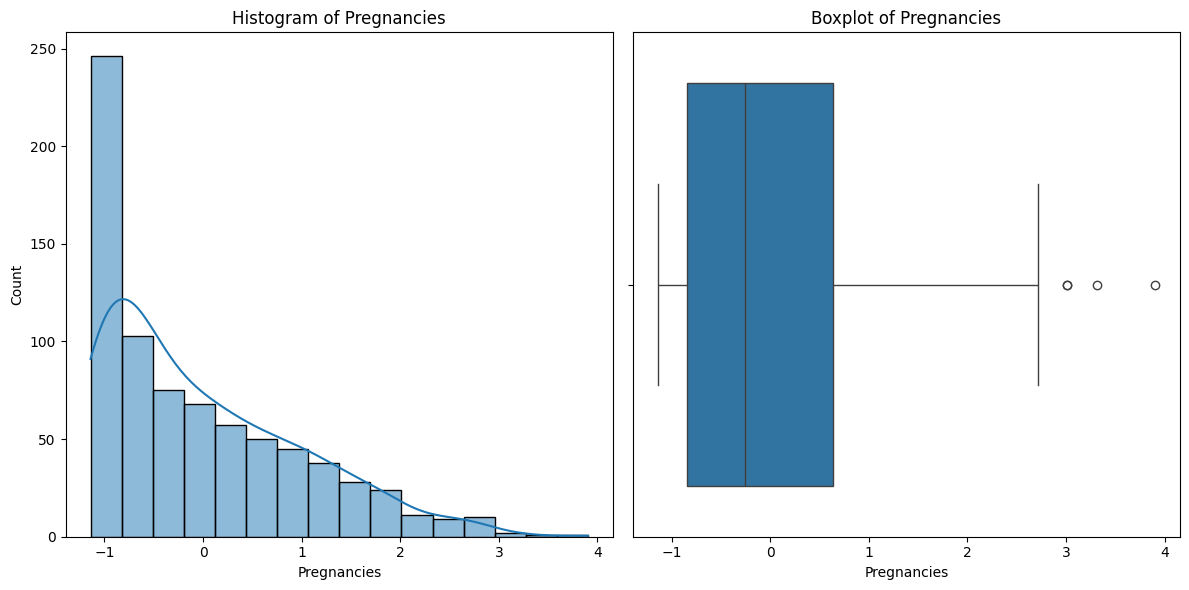

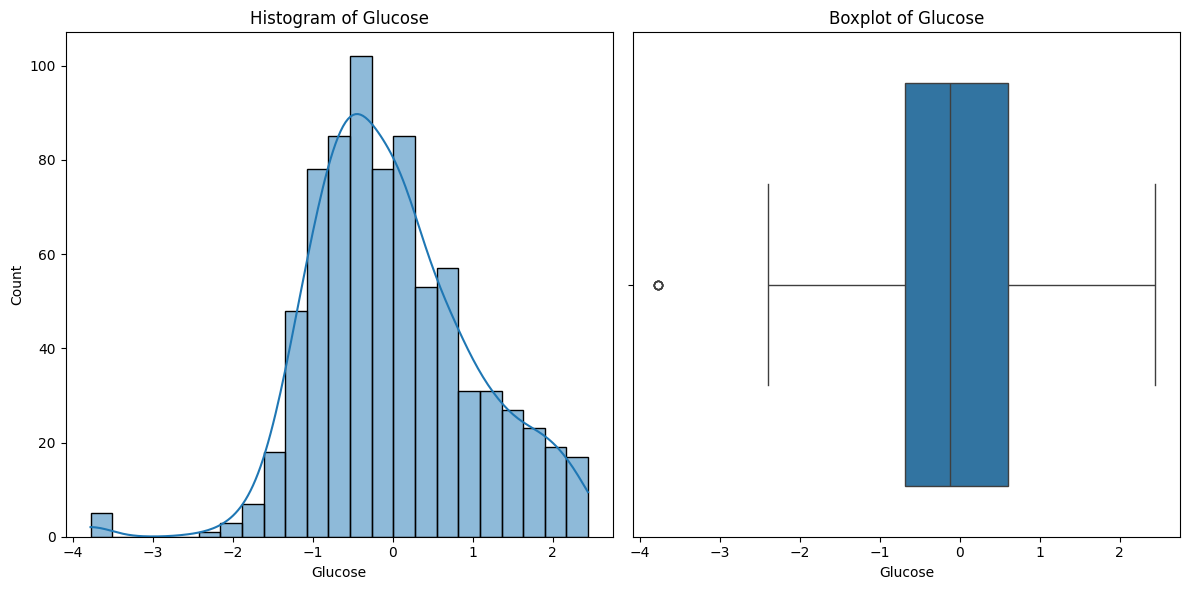

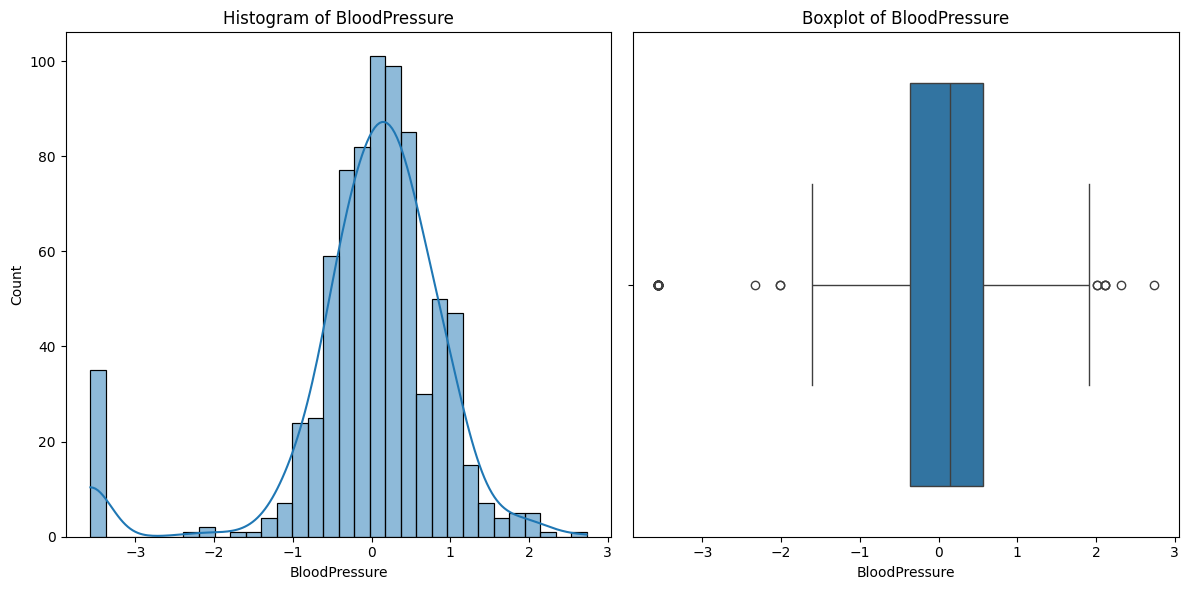

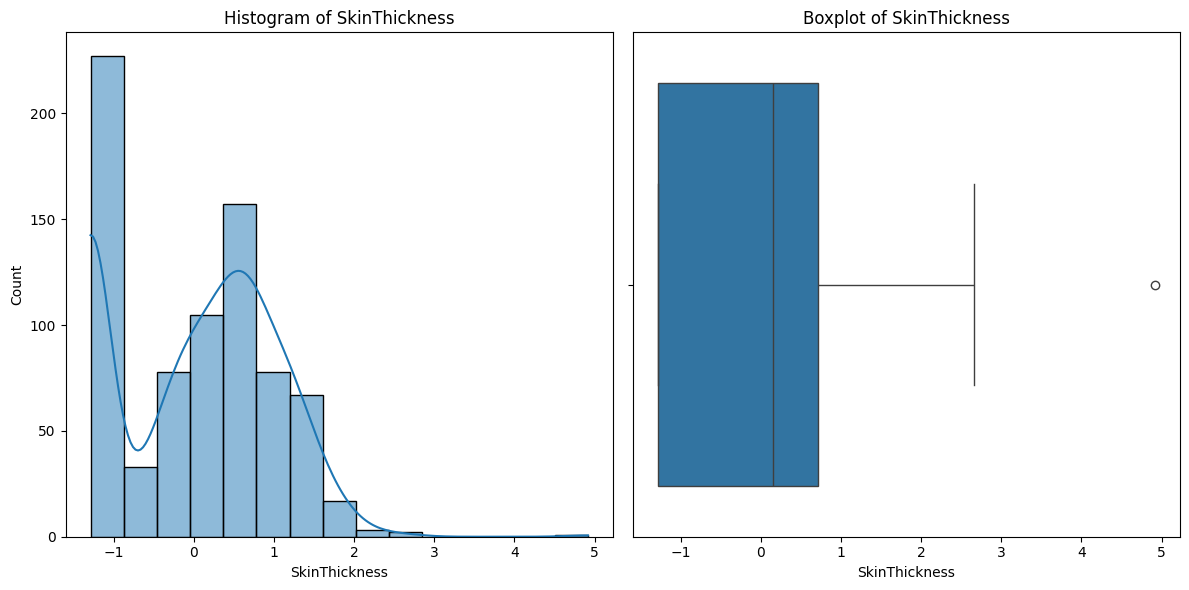

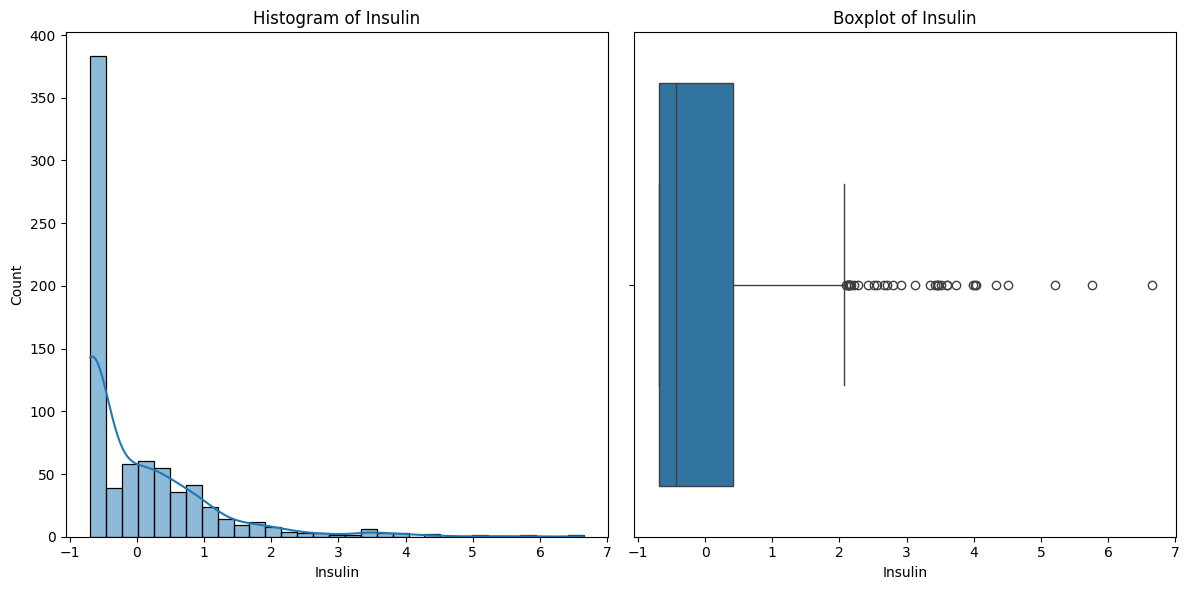

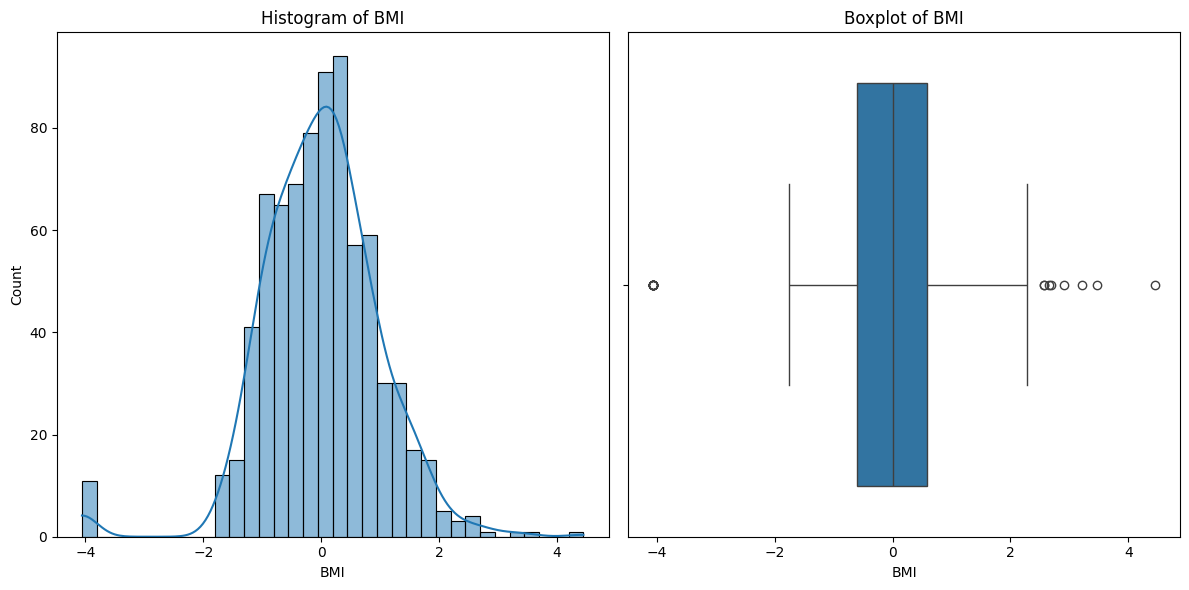

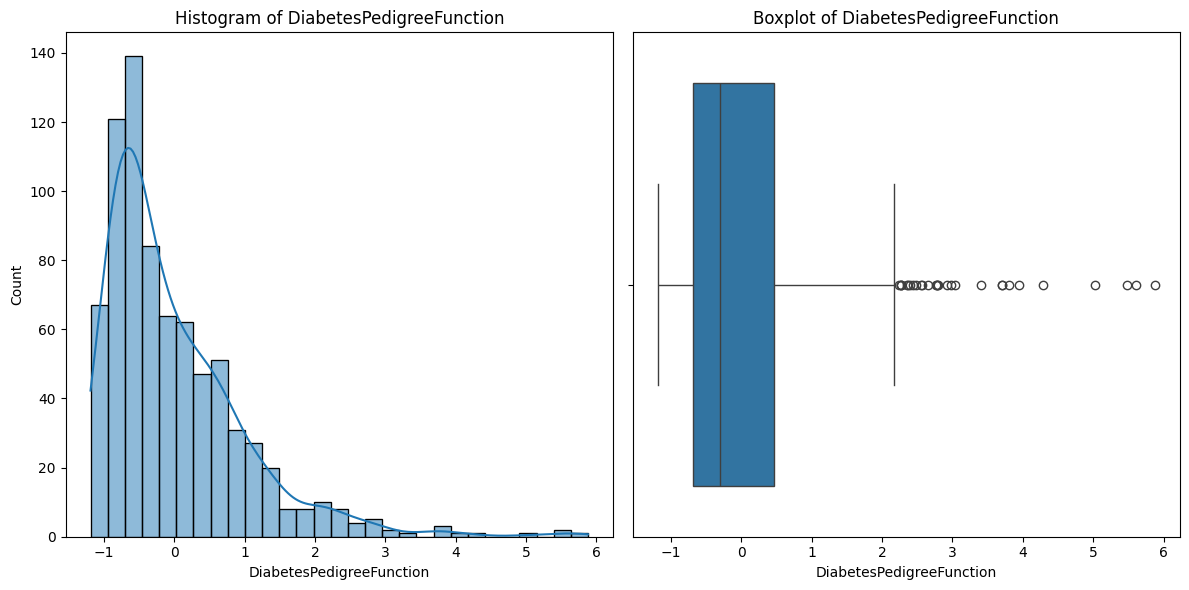

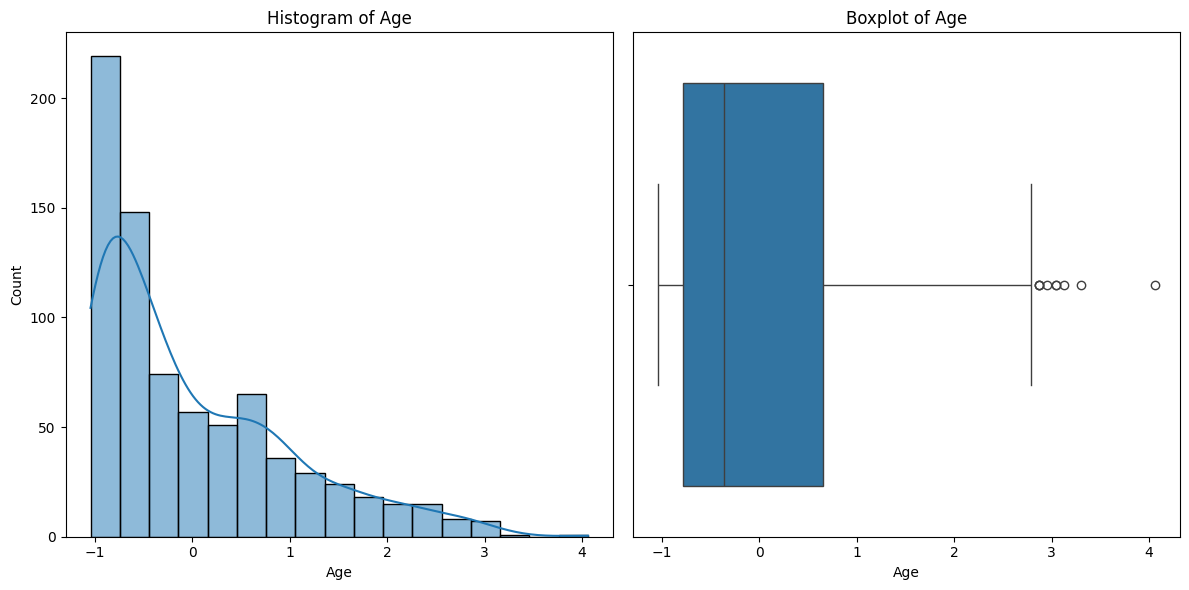

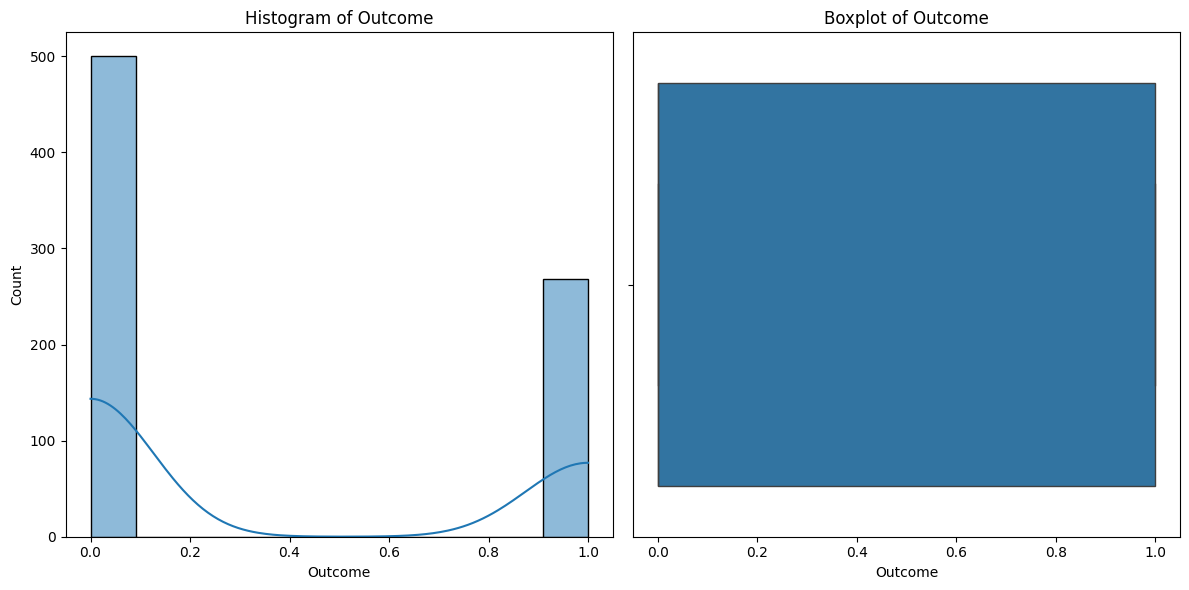

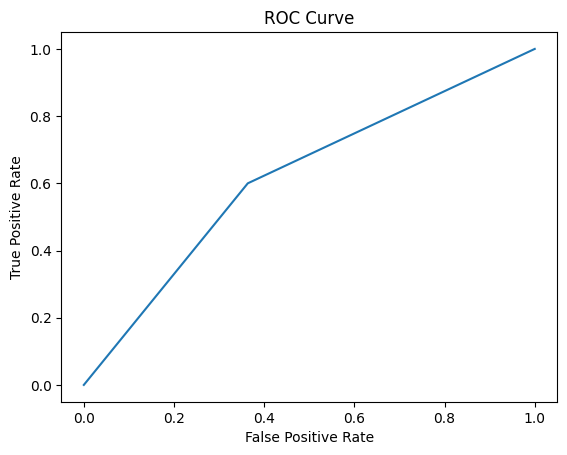

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.62,0.65,0.62,0.63,0.62


In [178]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
model = KMeans()
params = {'n_clusters':[2]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='PIMA')

## Interpretation of KMeans on Heart Disease Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>ROC-AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.62</td>
      <td>0.65</td>
      <td>0.62</td>
      <td>0.63</td>
      <td>0.62</td>
    </tr>
  </tbody>
</table>
</div>

**Moderate Performance**: The metrics show moderate performance, with accuracy at 0.62, precision at 0.65, recall at 0.62, F1-score at 0.63, and ROC-AUC at 0.62. These scores suggest that the clustering algorithm has some capability in identifying patterns within the dataset.

**Balanced Precision and Recall**: The precision and recall values are quite close, indicating a relatively balanced performance in correctly identifying positive instances (diabetes cases) while minimizing false positives.

**Room for Improvement**: While the algorithm shows promise, there is still room for improvement in terms of accuracy and overall predictive capability. Enhancements in clustering techniques or additional feature engineering may help improve the results.

**Consideration of Domain Knowledge**: Understanding the context and nuances of the Pima Indians Diabetes Dataset is crucial for interpreting these results accurately. Domain knowledge can provide insights into the significance of the identified clusters and their relevance to diabetes diagnosis.

**Further Evaluation Needed**: Given the moderate performance metrics, further evaluation of the clustering results is warranted. This could involve analyzing the characteristics of the clusters generated, assessing their interpretability, and potentially exploring alternative clustering algorithms or parameter settings to enhance performance.

# Using Random Forest Classifier on the Above Datasets

5-Number Summary:
              count  mean  std   min   25%   50%  75%  max
sepal_length 147.00 -0.00 1.00 -1.88 -0.91 -0.07 0.66 2.46
sepal_width  147.00  0.00 1.00 -2.42 -0.59 -0.13 0.56 3.08
petal_length 147.00 -0.00 1.00 -1.58 -1.24  0.35 0.75 1.77
petal_width  147.00 -0.00 1.00 -1.46 -1.20  0.12 0.78 1.70
class        147.00  1.01 0.82  0.00  0.00  1.00 2.00 2.00


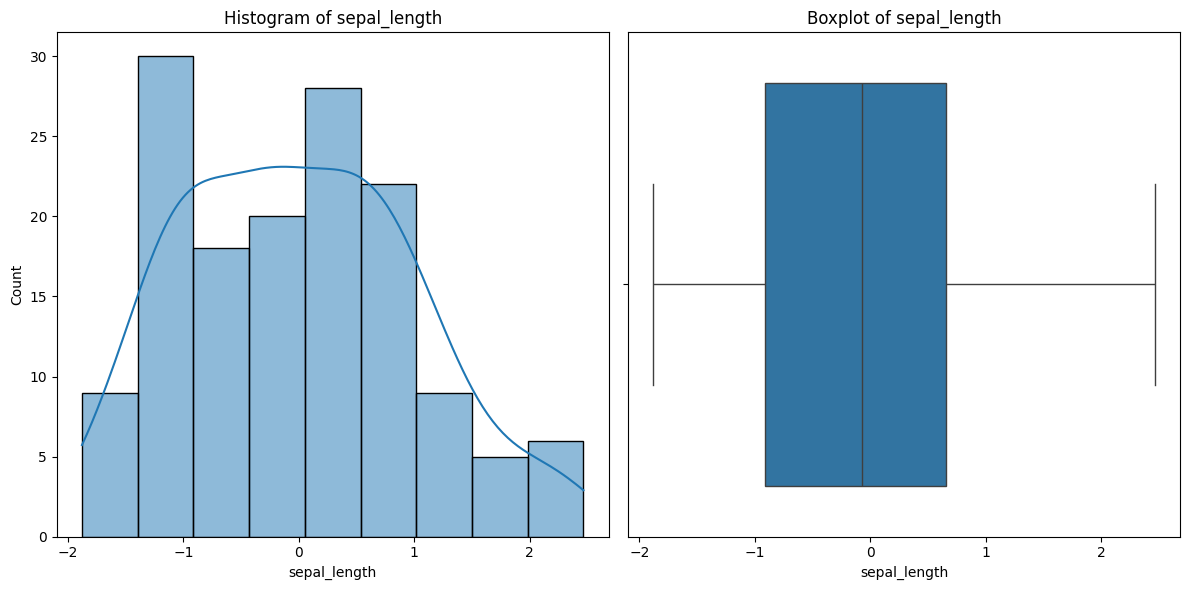

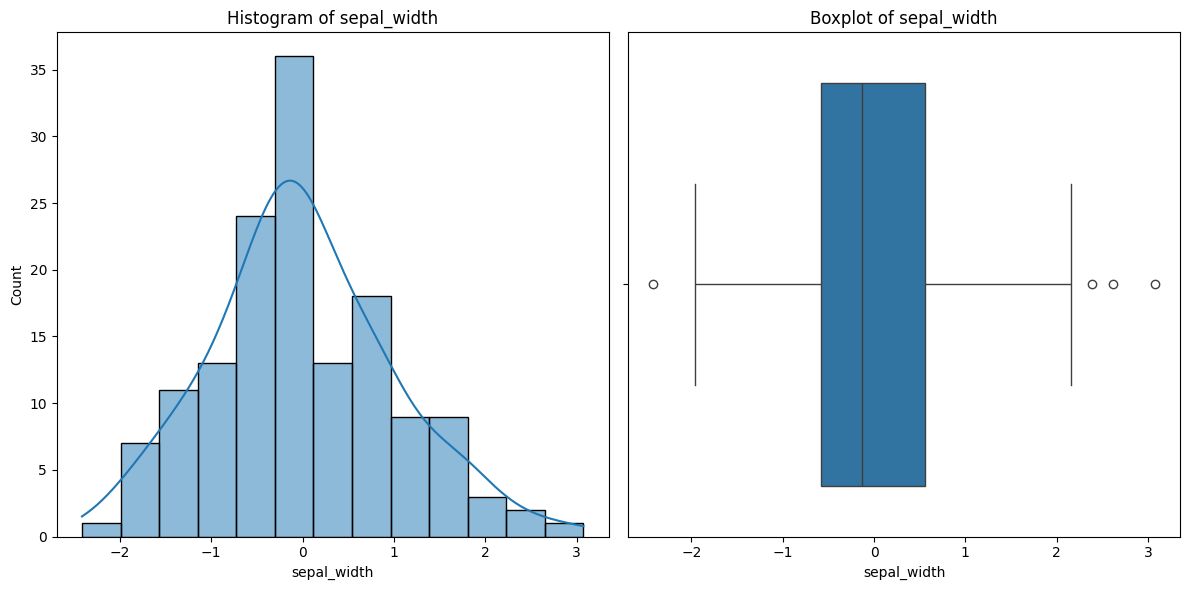

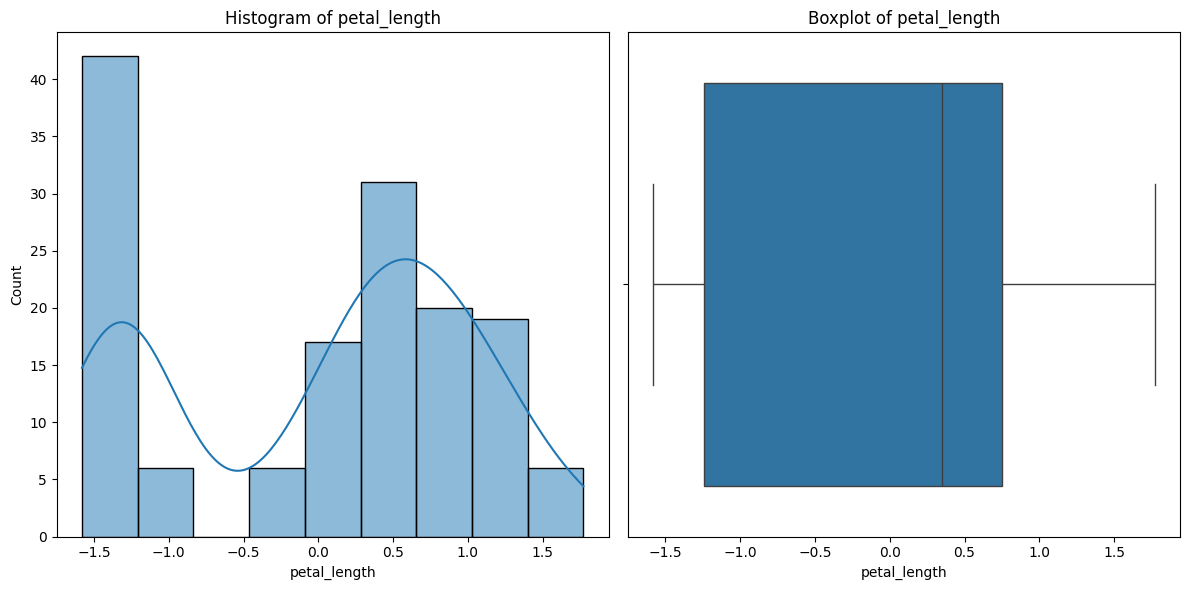

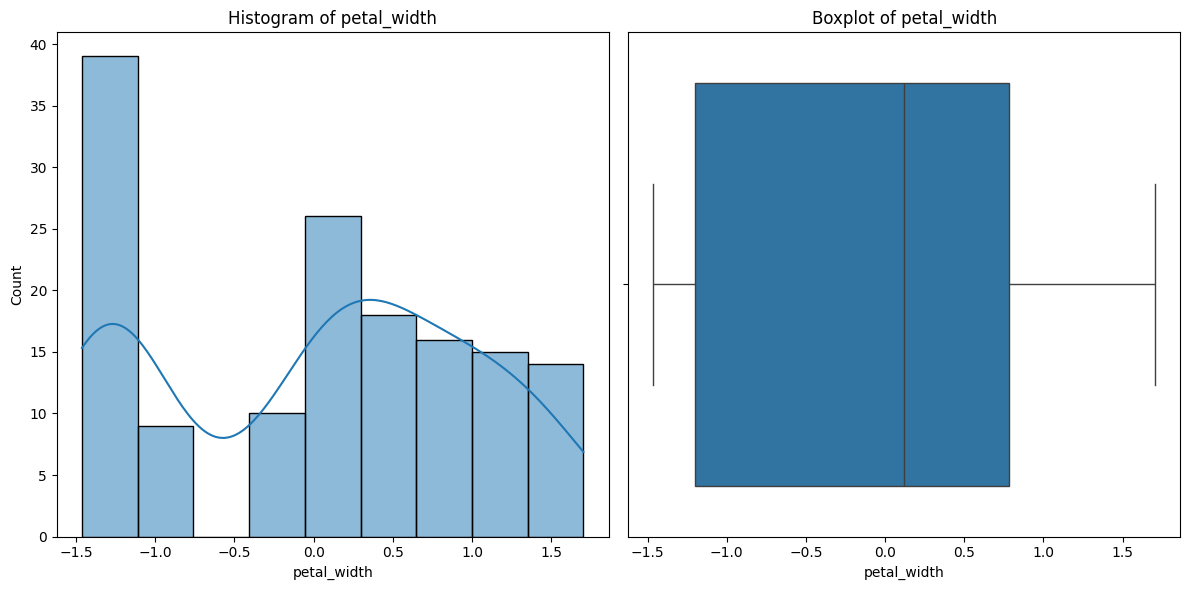

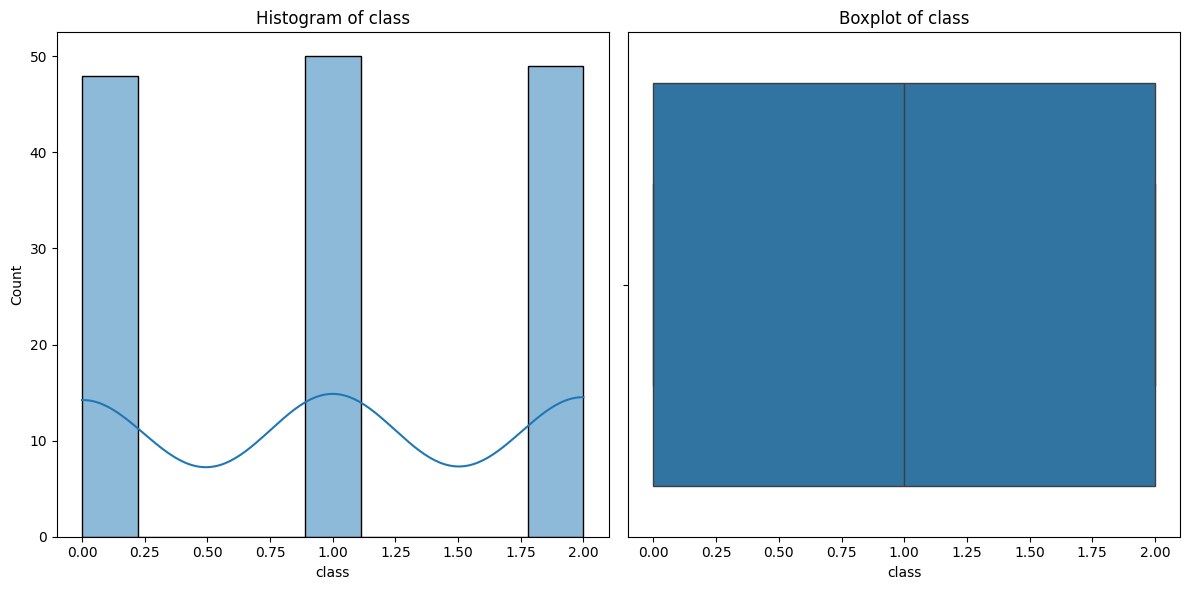

,Accuracy,Precision,Recall,F1-Score
0,0.93,0.93,0.93,0.93


In [179]:
from sklearn.ensemble import RandomForestClassifier


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

model = RandomForestClassifier()
params = {'n_estimators':[100]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='RF_Iris')

# Interpretation of Random Forest on Iris

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
      <td>0.93</td>
    </tr>
  </tbody>
</table>
</div>

**Random Forest Performance**: Random Forest achieves high scores across all metrics, indicating strong performance in classifying Iris dataset samples into their respective categories. The high values suggest that the model is effectively capturing the underlying patterns in the dataset.

**K-means Performance**: In contrast, K-means performs poorly with very low scores across all metrics. This suggests that K-means is not suitable for this classification task, as it's primarily used for clustering rather than classification.

**Significant Disparity**: There's a significant disparity between the performance of Random Forest and K-means. While Random Forest achieves near-perfect scores, K-means' scores are extremely low, indicating a lack of effectiveness in clustering the Iris dataset.

5-Number Summary:
                         count  mean  std   min   25%   50%  75%  max
Area                    210.00 -0.00 1.00 -1.46 -0.89 -0.17 0.84 2.18
Perimeter               210.00  0.00 1.00 -1.65 -0.85 -0.18 0.88 2.06
Compactness             210.00  0.00 1.00 -2.66 -0.60  0.10 0.71 2.00
Length_of_kernel        210.00 -0.00 1.00 -1.65 -0.83 -0.24 0.79 2.36
Width_of_kernel         210.00 -0.00 1.00 -1.66 -0.83 -0.06 0.80 2.05
Asymmetry_coefficient   210.00 -0.00 1.00 -1.95 -0.76 -0.07 0.71 3.16
Length_of_kernel_groove 210.00 -0.00 1.00 -1.81 -0.74 -0.38 0.95 2.32
Class                   210.00  2.00 0.82  1.00  1.00  2.00 3.00 3.00


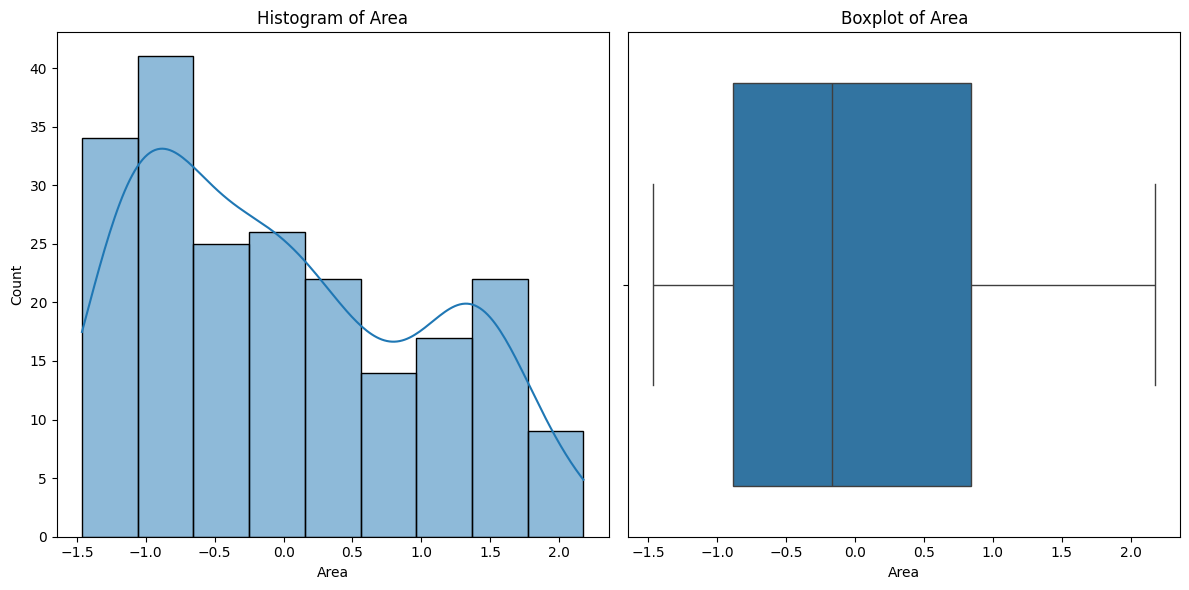

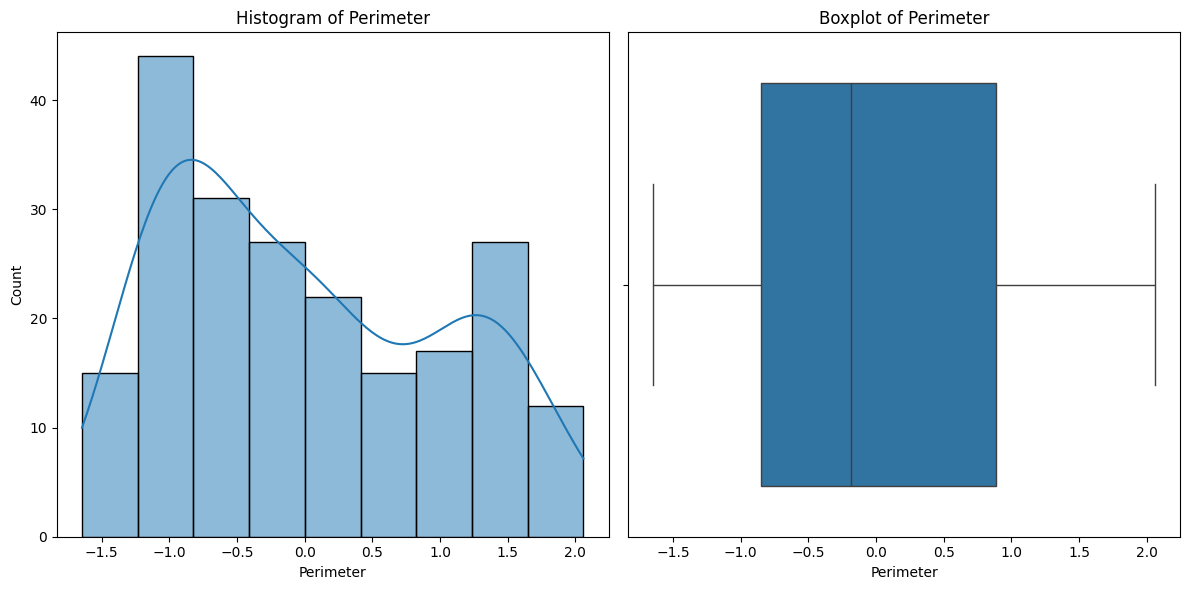

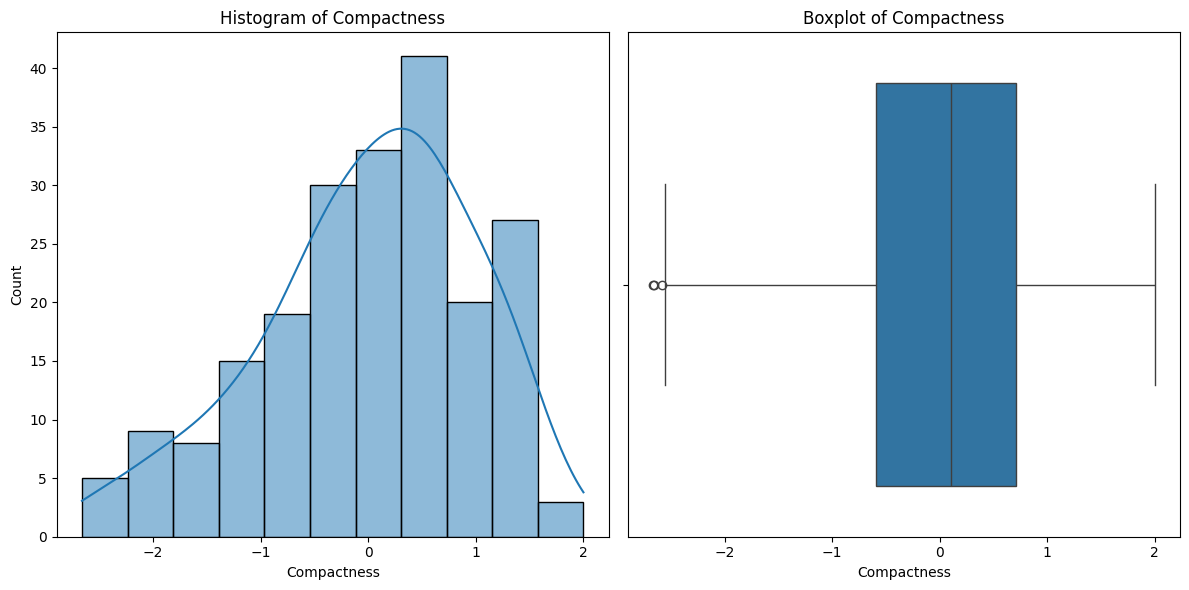

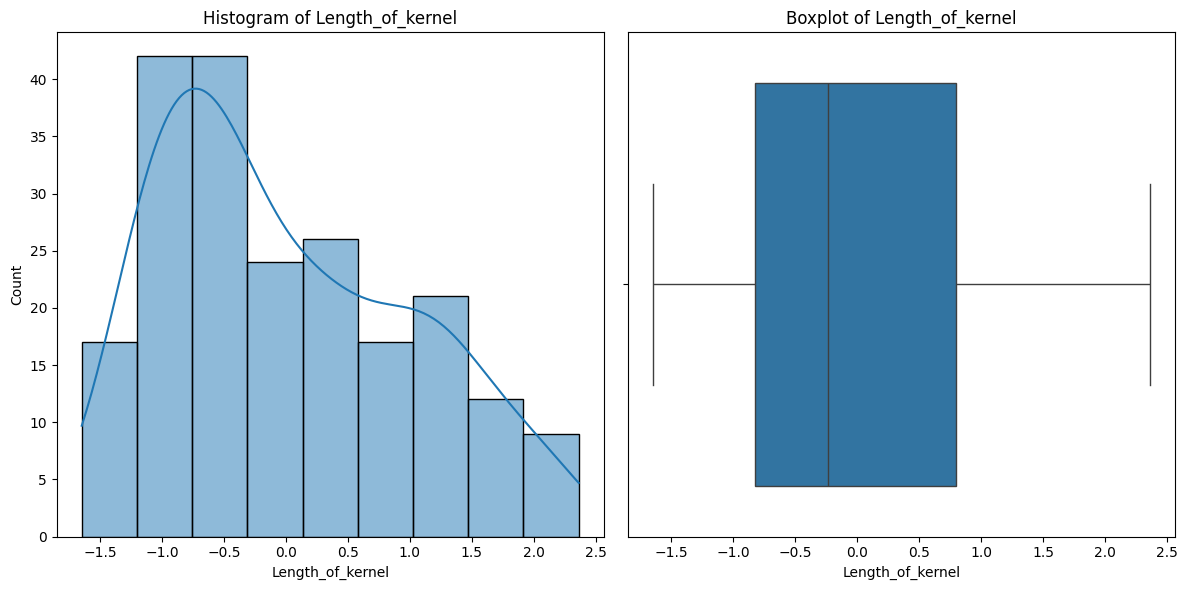

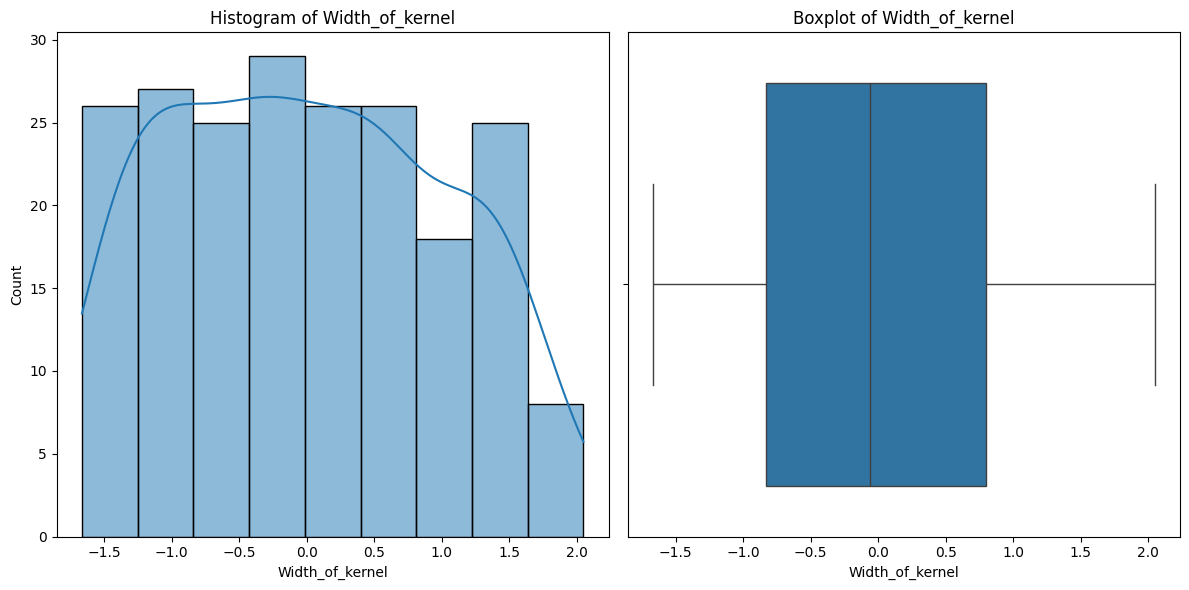

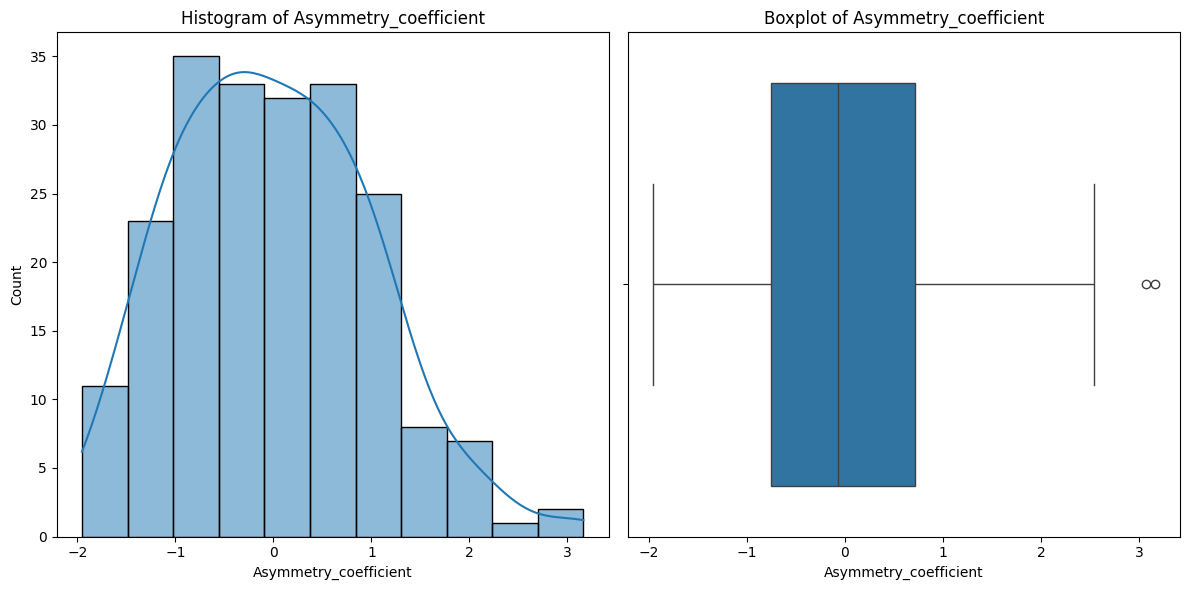

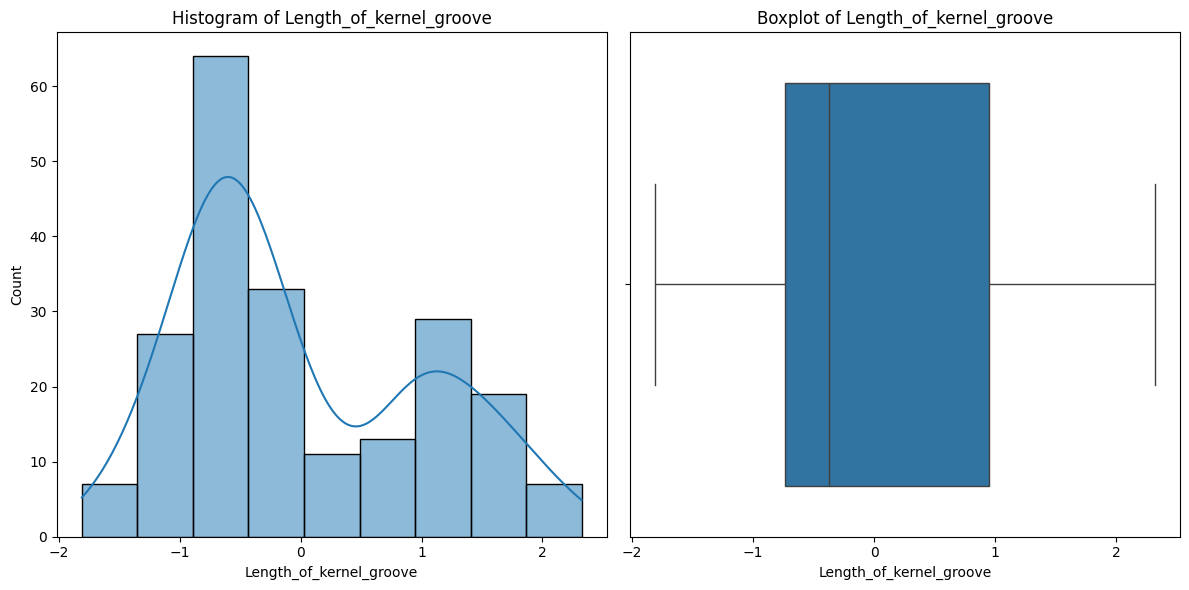

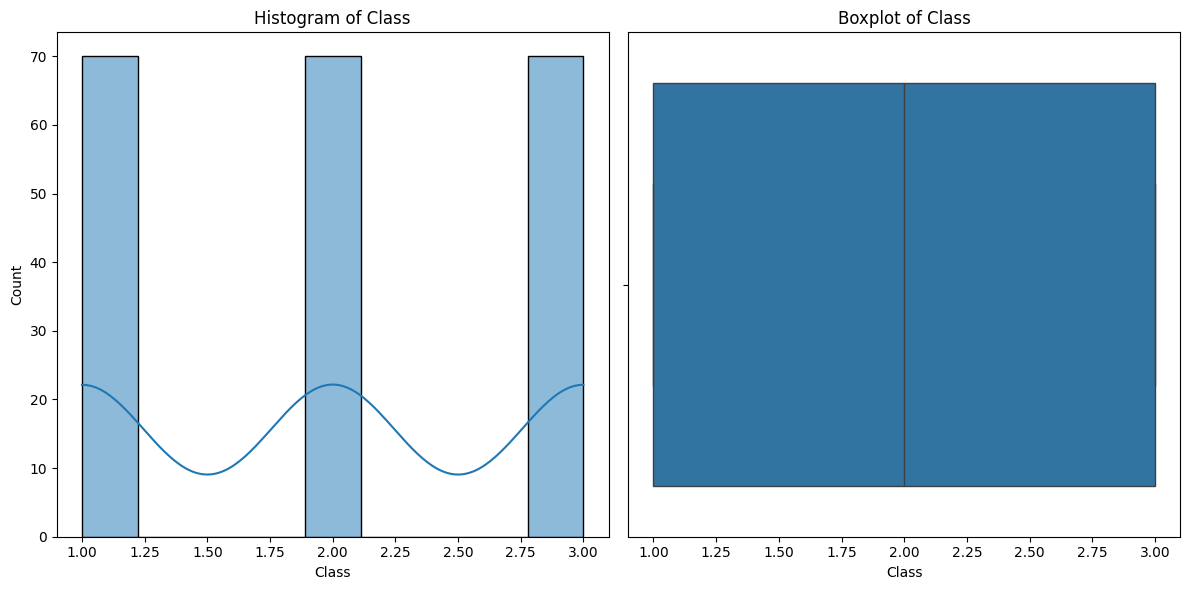

,Accuracy,Precision,Recall,F1-Score
0,0.88,0.90,0.88,0.88


In [180]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
column_names = ['Area', 'Perimeter', 'Compactness', 'Length_of_kernel', 'Width_of_kernel', 'Asymmetry_coefficient', 'Length_of_kernel_groove', 'Class']

model = RandomForestClassifier()
params = {'n_estimators':[100]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params, sheet_name='RF_Seeds')

# Interpretation of Random Forest on Seeds Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.88</td>
      <td>0.90</td>
      <td>0.88</td>
      <td>0.88</td>
    </tr>
  </tbody>
</table>
</div>

**Random Forest Performance**: Random Forest achieves relatively high scores across all metrics, indicating strong performance in classifying the Seeds dataset samples into their respective categories. The high values suggest that the model effectively captures the underlying patterns in the dataset.

**K-means Performance**: In contrast, K-means performs poorly with low scores across all metrics. This suggests that K-means is not suitable for this classification task, as it's primarily used for clustering rather than classification.

**Significant Disparity**: There's a significant disparity between the performance of Random Forest and K-means. While Random Forest achieves high scores, K-means' scores are considerably lower, indicating a lack of effectiveness in clustering the Seeds dataset.

5-Number Summary:
                          count  mean  std   min   25%   50%  75%  max
Pregnancies              768.00 -0.00 1.00 -1.14 -0.84 -0.25 0.64 3.90
Glucose                  768.00 -0.00 1.00 -3.78 -0.68 -0.12 0.61 2.44
BloodPressure            768.00  0.00 1.00 -3.57 -0.37  0.15 0.56 2.73
SkinThickness            768.00  0.00 1.00 -1.29 -1.29  0.15 0.72 4.92
Insulin                  768.00 -0.00 1.00 -0.69 -0.69 -0.43 0.41 6.65
BMI                      768.00  0.00 1.00 -4.06 -0.60  0.00 0.58 4.45
DiabetesPedigreeFunction 768.00  0.00 1.00 -1.19 -0.69 -0.30 0.47 5.88
Age                      768.00  0.00 1.00 -1.04 -0.79 -0.36 0.66 4.06
Outcome                  768.00  0.35 0.48  0.00  0.00  0.00 1.00 1.00


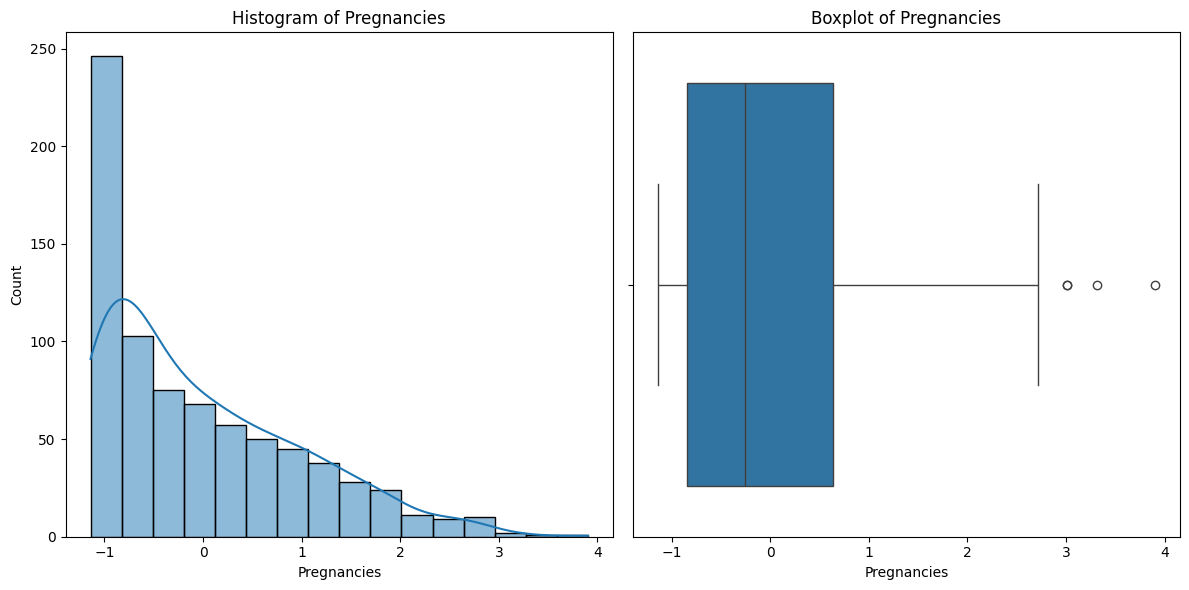

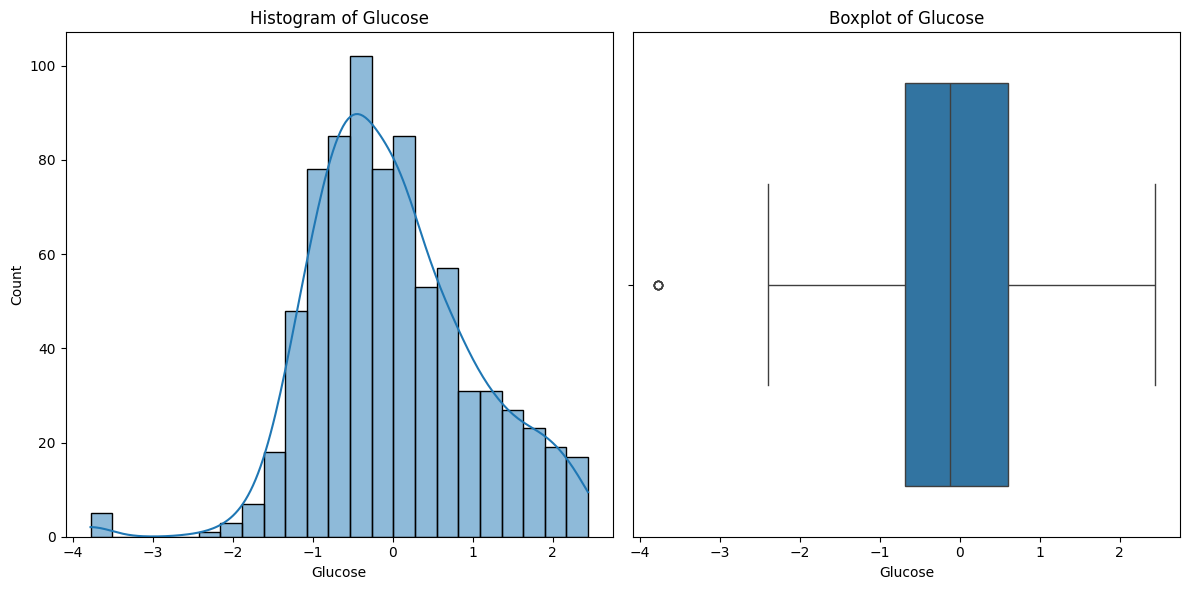

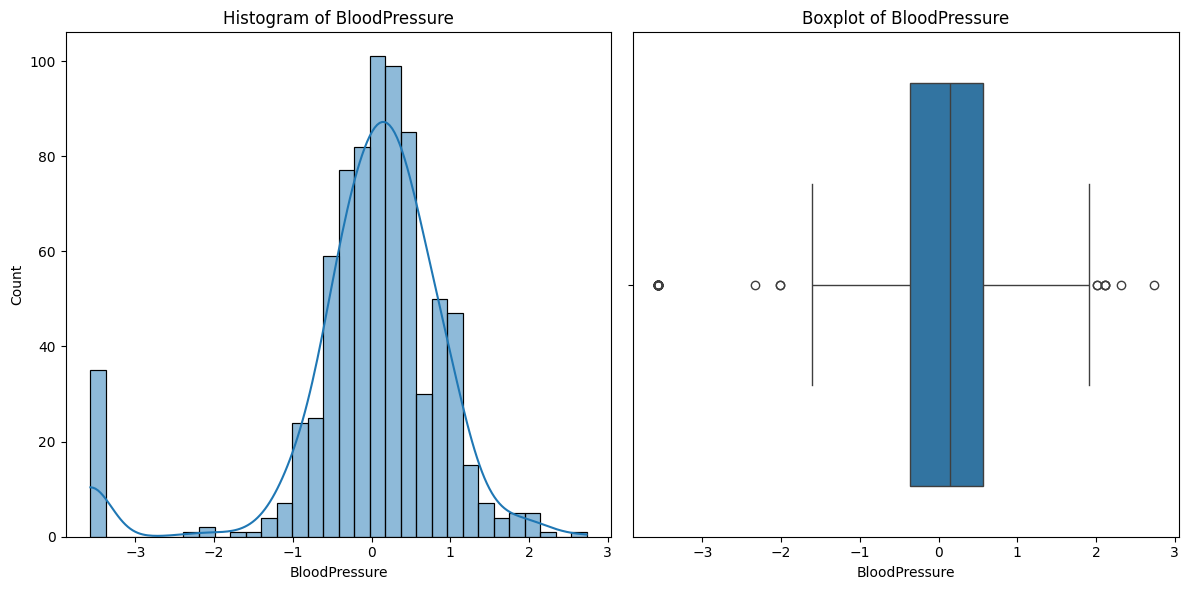

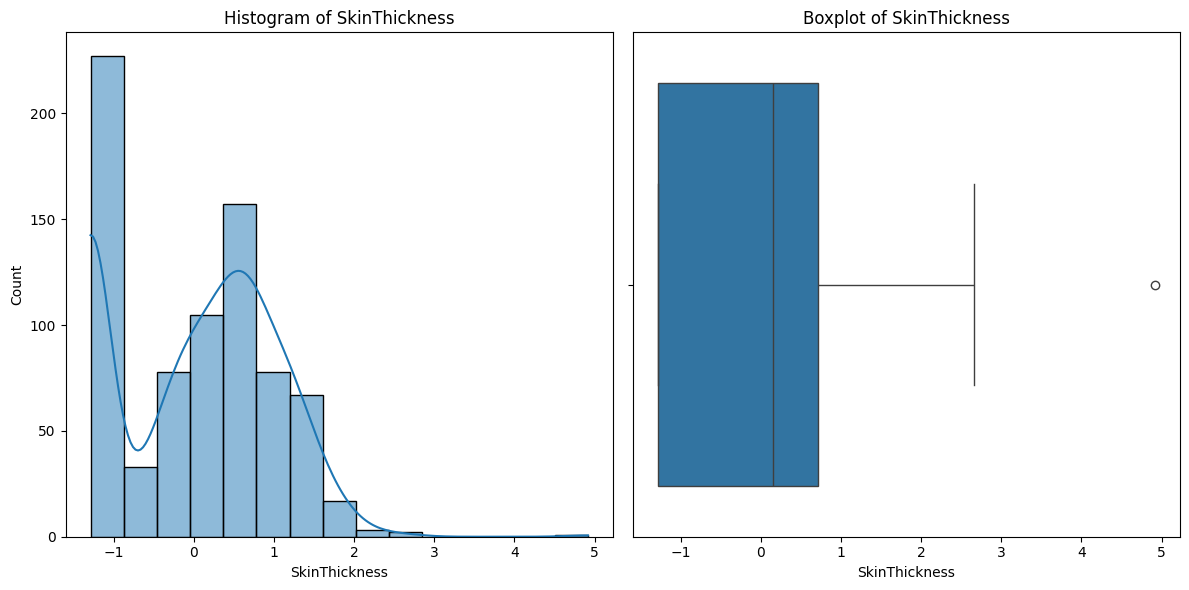

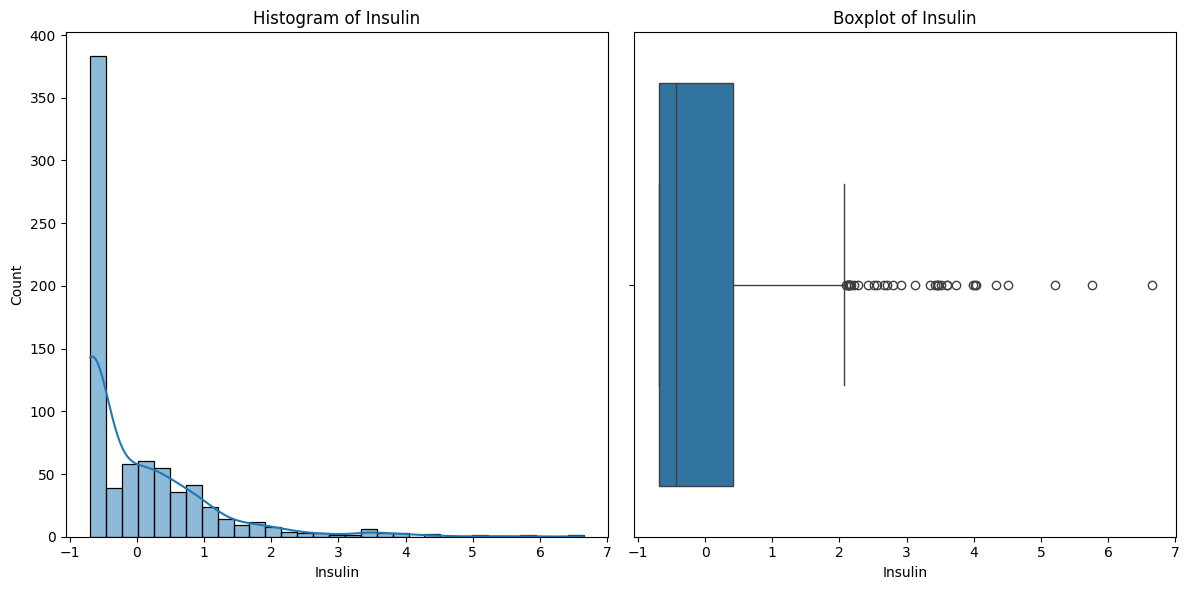

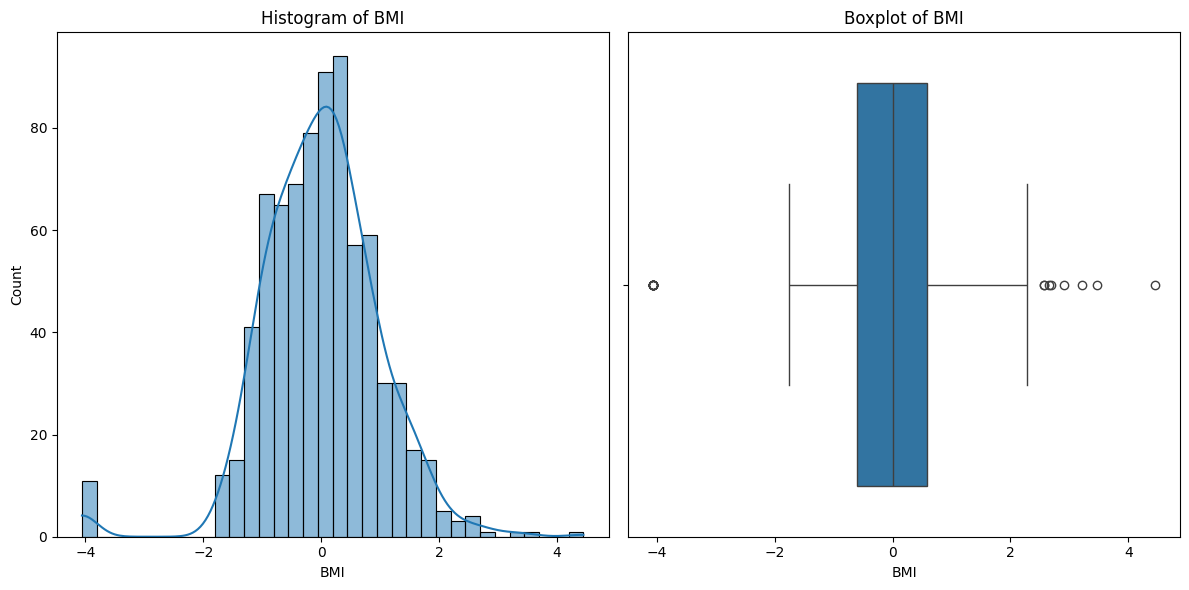

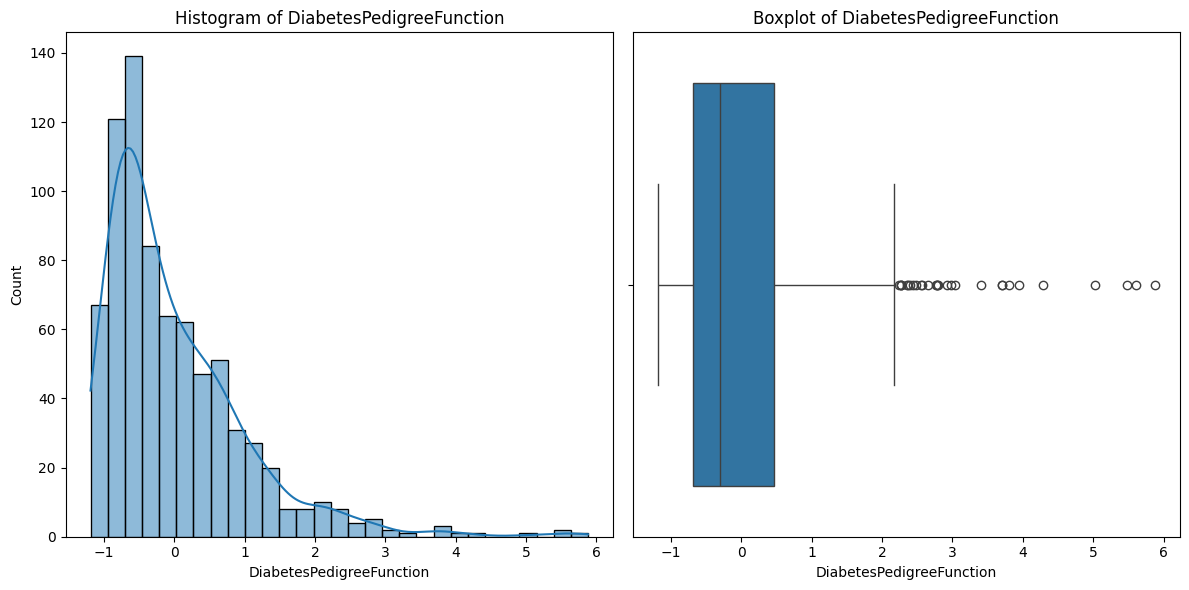

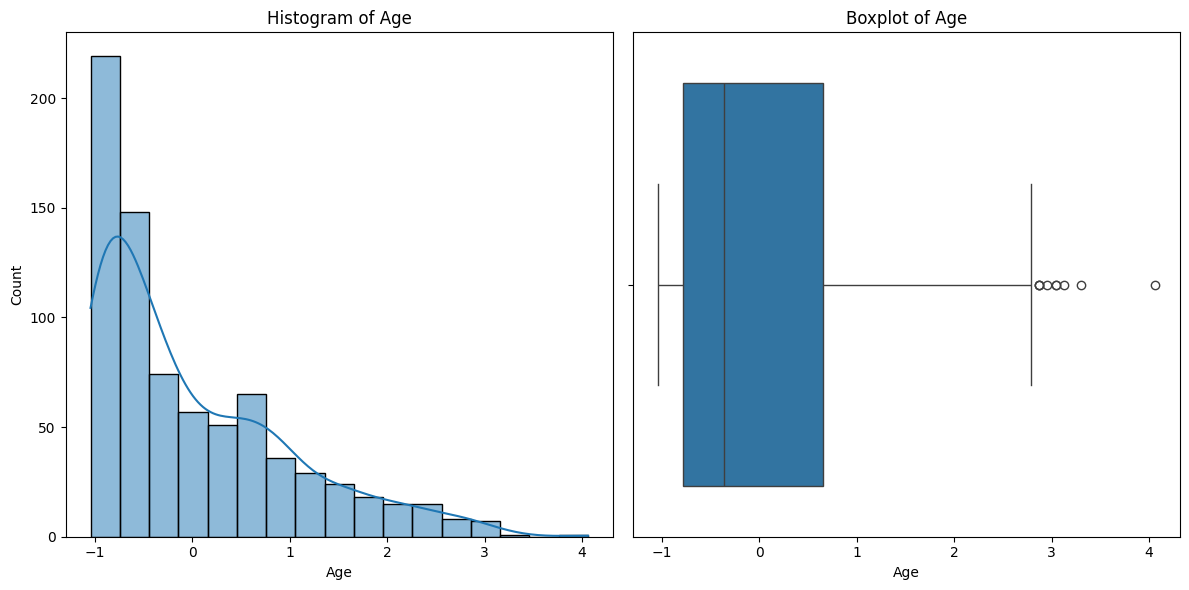

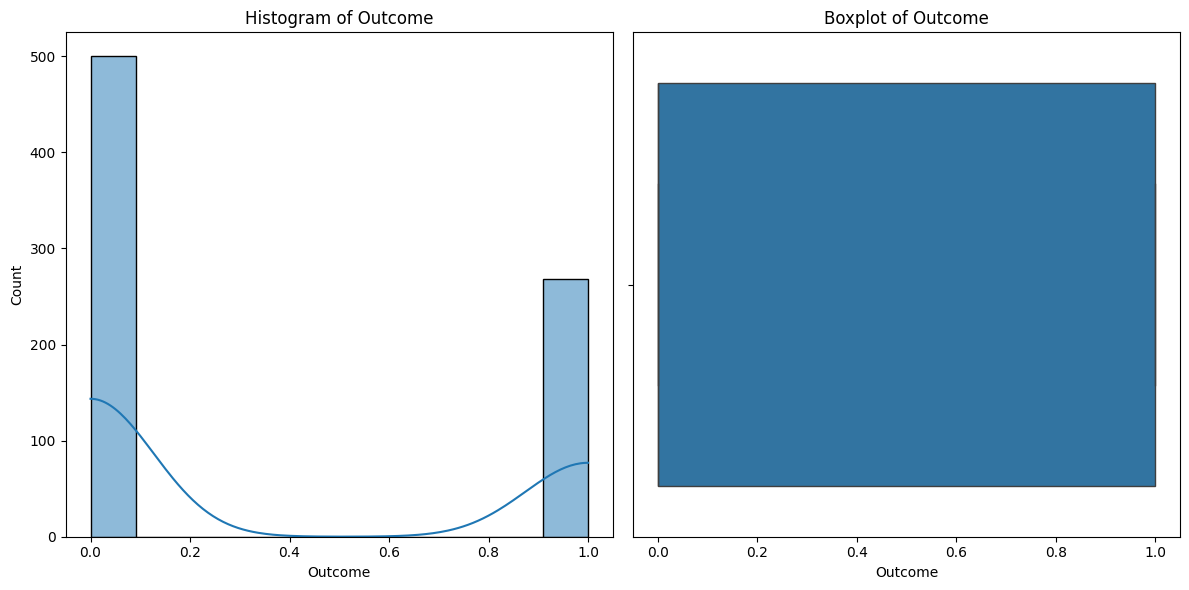

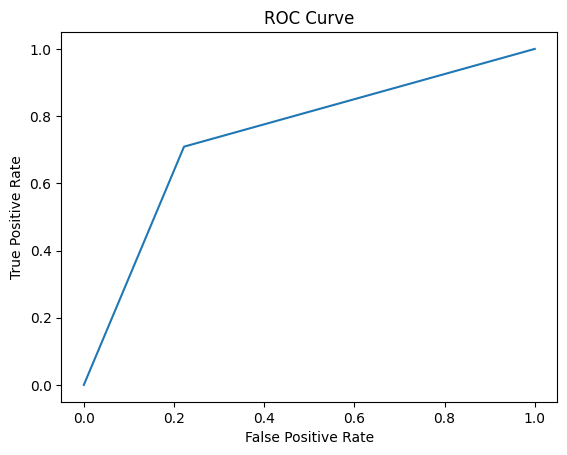

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.75,0.76,0.75,0.76,0.74


In [181]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

model = RandomForestClassifier()
params = {'n_estimators':[100]}
master(url,column_names = column_names, problem_type='classification',model=model, params=params, sheet_name='RF_PIMA')

# Interpretation of Random Forest on PIMA INDIAN Dataset

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1-Score</th>
      <th>ROC-AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.75</td>
      <td>0.76</td>
      <td>0.75</td>
      <td>0.76</td>
      <td>0.74</td>
    </tr>
  </tbody>
</table>
</div>

**Random Forest Performance**: Random Forest achieves moderate to good scores across all metrics, indicating relatively strong performance in classifying instances in the Pima Indian Diabetes Dataset. The accuracy, precision, recall, and F1-score are all around 0.75 to 0.76, suggesting effective classification. The ROC-AUC score of 0.74 also indicates good discrimination between positive and negative instances.

**K-means Performance**: K-means performs slightly poorer with lower scores across all metrics. While the accuracy is 0.62 and precision is 0.65, the recall, F1-score, and ROC-AUC are around 0.62 to 0.63. These scores suggest that K-means struggles to effectively cluster instances in the Pima Indian Diabetes Dataset.

**Algorithm Suitability**: The results highlight the importance of choosing the appropriate algorithm for the task. Random Forest, a supervised learning algorithm, is well-suited for classification tasks like the Pima Indian Diabetes Dataset. In contrast, K-means, an unsupervised clustering algorithm, is not suitable for this classification task.